# Chapter 4

## Set Up

### Packages

In [1]:
import os

import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pymc as pm
import seaborn as sns
from scipy import stats
from scipy.interpolate import BSpline

WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


### Defaults

In [2]:
# seaborn defaults
sns.set(
    style="whitegrid",
    font_scale=1.2,
    rc={
        "axes.edgecolor": "0",
        "axes.grid.which": "both",
        "axes.labelcolor": "0",
        "axes.spines.right": False,
        "axes.spines.top": False,
        "xtick.bottom": True,
        "ytick.left": True,
    },
)

colors = sns.color_palette()

### Constants

In [3]:
DATA_DIR = "../data"
HOWELL_FILE = "howell.csv"
CHERRY_BLOSSOMS_FILE = "cherry_blossoms.csv"

RANDOM_SEED = 42

In [4]:
def load_data(file_name, data_dir=DATA_DIR, **kwargs):
    path = os.path.join(data_dir, file_name)
    return pd.read_csv(path, **kwargs)

## 4.3 Gaussian model of height

### 4.3.1 The data

In [5]:
# load data
howell = load_data(HOWELL_FILE, delimiter=";")

# get adult heights
height = howell.loc[howell["age"] >= 18, "height"].values

Plot the distribution

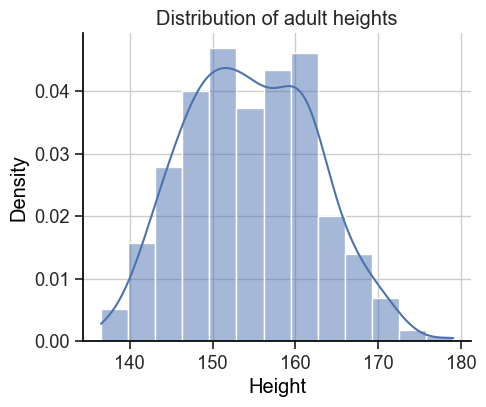

In [6]:
fig, ax = plt.subplots(figsize=(5, 4))

sns.histplot(height, kde=True, stat="density")

ax.set(
    xlabel="Height",
    title="Distribution of adult heights",
);

### 4.3.2 The model

Set and plot priors

In [7]:
def plot_priors(priors):
    n_priors = len(priors)

    ax_width = 6
    width = ax_width * n_priors

    fig, axs = plt.subplots(ncols=n_priors, figsize=(width, 4))

    for ax, (name, prior) in zip(axs, priors.items()):
        x_min, x_max = prior.ppf([0.001, 0.999])
        x_plot = np.linspace(x_min, x_max, 1000)
        y_plot = prior.pdf(x_plot)

        ax.plot(x_plot, y_plot)

        ax.set(ylabel="Density", title=name)

    fig.suptitle("Prior Density Functions")

    return fig, axs

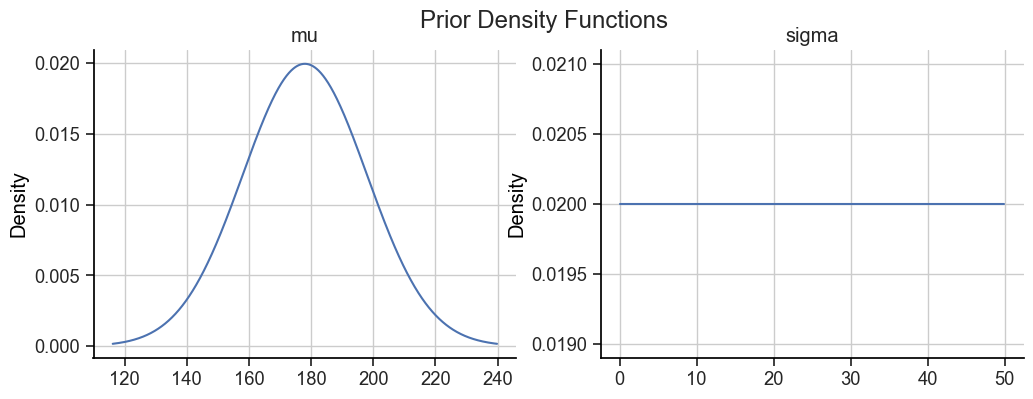

In [8]:
# priors
mu_prior = stats.norm(loc=178, scale=20)
sigma_prior = stats.uniform(0, 50)

priors = {
    "mu": mu_prior,
    "sigma": sigma_prior,
}
plot_priors(priors);

Plot the prior predictive

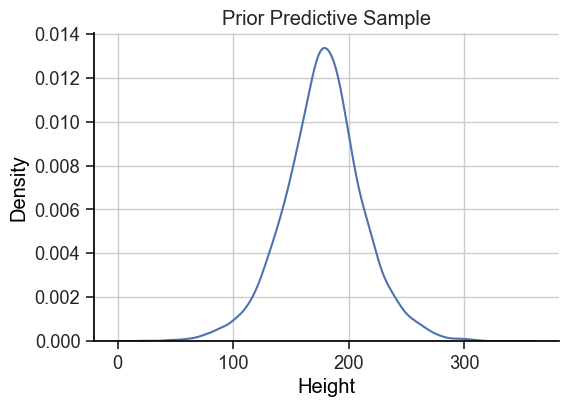

In [9]:
n_sample = 10000
mu_sample = mu_prior.rvs(n_sample)
sigma_sample = sigma_prior.rvs(n_sample)

prior_pred_sample = stats.norm.rvs(loc=mu_sample, scale=sigma_sample, size=n_sample)

# plot distribution
fig, ax = plt.subplots(figsize=(6, 4))

sns.kdeplot(prior_pred_sample, ax=ax)

ax.set(xlabel="Height", title="Prior Predictive Sample");

### 4.3.3 Grid approximation of the posterior distribution

In [10]:
def calculate_height_posterior_with_grid_approximation(
    height, mu_range, mu_prior, sigma_range, sigma_prior
):
    # take cross-product to get grids of pairs
    mu_grid, sigma_grid = np.meshgrid(mu_range, sigma_range)

    # get total log likelihood by taking sum of log likelihoods for each observation
    log_likelihood = np.array(
        [
            stats.norm.logpdf(height[i], loc=mu_grid, scale=sigma_grid)
            for i in range(len(height))
        ]
    ).sum(axis=0)

    # get log prior values at grid points
    mu_prior_log_val = mu_prior.logpdf(mu_grid)
    sigma_prior_log_val = sigma_prior.logpdf(sigma_grid)

    # update prior in log world
    log_posterior = log_likelihood + mu_prior_log_val + sigma_prior_log_val

    # get posterior
    posterior = np.exp(log_posterior - np.max(log_posterior))
    posterior /= posterior.sum()

    return posterior, mu_grid, sigma_grid

In [11]:
mu_range = np.linspace(150, 169, 100)
sigma_range = np.linspace(7, 9, 100)

posterior, mu_grid, sigma_grid = calculate_height_posterior_with_grid_approximation(
    height, mu_range, mu_prior, sigma_range, sigma_prior
)

Plot joint distribution of posterior

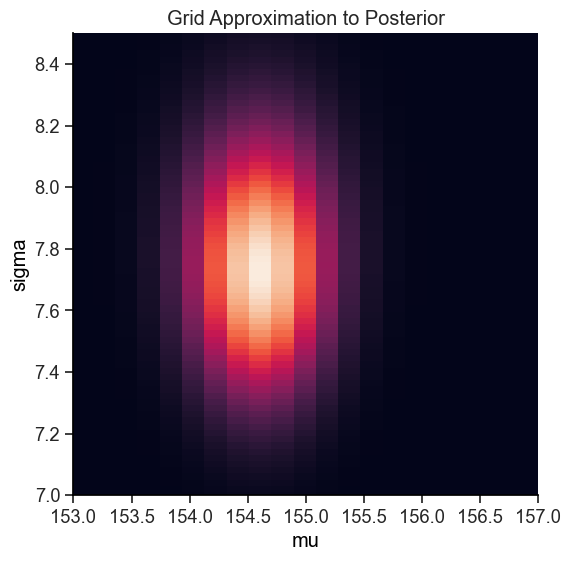

In [12]:
fig, ax = plt.subplots(figsize=(6, 6))

ax.pcolormesh(mu_grid, sigma_grid, posterior)

ax.set(
    xlim=[153, 157],
    ylim=[7, 8.5],
    xlabel="mu",
    ylabel="sigma",
    title="Grid Approximation to Posterior",
);

### 4.3.4 Sampling from the posterior

We sample the index of the ravelled grid and use this to sample mu and sigma.

In [13]:
def sample_height_posterior(posterior):
    n_sample = np.prod(posterior.shape)
    grid_ravel_idx = np.arange(n_sample)

    samples_idx = np.random.choice(
        grid_ravel_idx, size=n_sample, p=posterior.ravel(), replace=True
    )

    mu_samples = mu_grid.ravel()[samples_idx]
    sigma_samples = sigma_grid.ravel()[samples_idx]

    return mu_samples, sigma_samples

In [14]:
mu_samples, sigma_samples = sample_height_posterior(posterior)

Plot the posterior sample

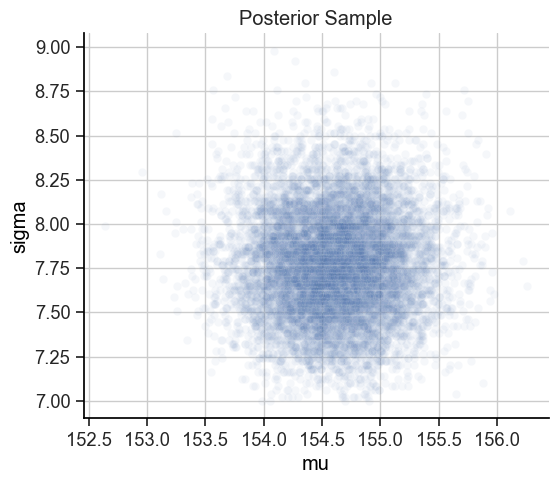

In [15]:
fig, ax = plt.subplots(figsize=(6, 5))

# add some jitter or the points are all on top of each other
mu_jitter_std = 0.1
mu_jitter = stats.norm.rvs(loc=0, scale=mu_jitter_std, size=len(mu_samples))

sns.scatterplot(
    x=mu_samples + mu_jitter,
    y=sigma_samples,
    alpha=0.05,
    ax=ax,
)

ax.set(
    xlabel="mu",
    ylabel="sigma",
    title="Posterior Sample",
);

We can also plot a joint density plot

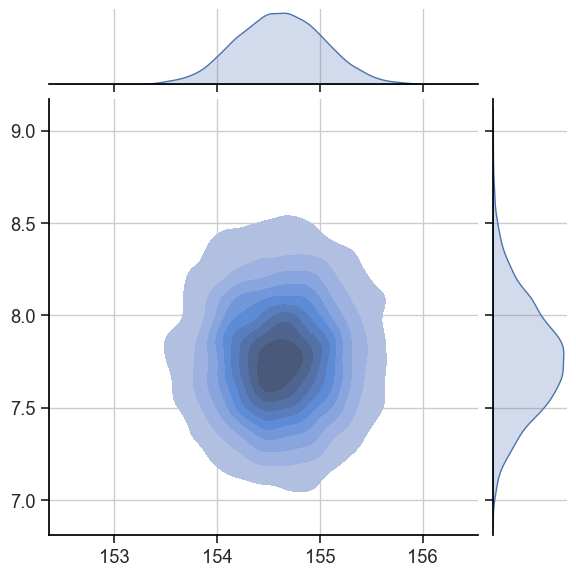

In [16]:
sns.jointplot(
    x=mu_samples + mu_jitter,
    y=sigma_samples,
    kind="kde",
    fill=True,
);

Try repeating the above with less data

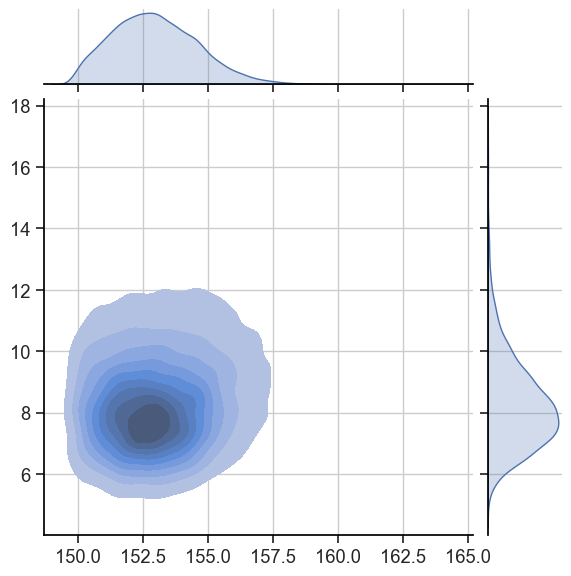

In [17]:
mu_range = np.linspace(150, 170, 100)
sigma_range = np.linspace(4, 20, 100)

height_sample = np.random.choice(height, size=20, replace=False)
posterior, mu_grid, sigma_grid = calculate_height_posterior_with_grid_approximation(
    height_sample, mu_range, mu_prior, sigma_range, sigma_prior
)

mu_samples, sigma_samples = sample_height_posterior(posterior)

sns.jointplot(
    x=mu_samples + mu_jitter,
    y=sigma_samples,
    kind="kde",
    fill=True,
);

The posterior is a lot wider and the parameter $\sigma$ is a lot less normal - it has a long tail.

### 4.3.5 Finding the posterior distribution with `quap`

Now let's try generating the posterior using PyMC, since we don't have a package to do quadratic approximation

In [18]:
# load data
howell = load_data(HOWELL_FILE, delimiter=";")

# get adult heights
data = howell.loc[howell["age"] >= 18, "height"]

In [19]:
with pm.Model() as m4_1:
    # stochastic random variables (priors)
    mu = pm.Normal("mu", mu=178, sigma=20)
    sigma = pm.Uniform("sigma", lower=0, upper=50)

    # observed stochastic (likelihood)
    height = pm.Normal("height", mu=mu, sigma=sigma, observed=data)

    # draw 1000 posterior samples
    # returns InferenceData object
    trace_4_1 = pm.sample()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu, sigma]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 1 seconds.


Get summary stats for the posterior distributions

In [20]:
az.summary(trace_4_1, kind="stats", hdi_prob=0.89, round_to=2)

mean    sd  hdi_5.5%  hdi_94.5%
mu     154.60  0.43    153.93     155.27
sigma    7.77  0.30      7.35       8.30

Try more informative priors:

In [21]:
with pm.Model() as m4_2:
    # stochastic random variables (priors)
    mu = pm.Normal("mu", mu=178, sigma=0.1)
    sigma = pm.Uniform("sigma", lower=0, upper=50)

    # observed stochastic (likelihood)
    height = pm.Normal("height", mu=mu, sigma=sigma, observed=data)

    # draw 1000 posterior samples
    trace_4_2 = pm.sample()

az.summary(trace_4_2, kind="stats", hdi_prob=0.89, round_to=2)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu, sigma]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 1 seconds.


mean    sd  hdi_5.5%  hdi_94.5%
mu     177.86  0.10    177.70     178.02
sigma   24.57  0.94     23.03      26.04

## 4.4 Linear prediction

Plot height against weight.

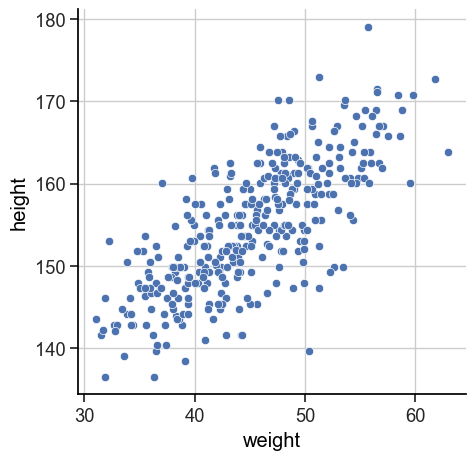

In [22]:
# load data
howell = load_data(HOWELL_FILE, delimiter=";")
adult = howell.loc[howell["age"] >= 18, :]

# plot height against weight
fig, ax = plt.subplots(figsize=(5, 5))

sns.scatterplot(adult, x="weight", y="height", ax=ax);

### 4.4.1 The linear model strategy

Simulate linear relationships by sampling priors

In [23]:
def plot_linear_weight_model_prior_predictive_manual(
    adult, alpha_prior, beta_prior, n_draw=100, ax=None
):
    # sample the priors
    alpha_sample = alpha_prior.rvs(size=n_draw)
    beta_sample = beta_prior.rvs(size=n_draw)

    weights = adult.weight.values

    # coerce into shapes (n_weight, n_draw)
    alpha_grid, weights_grid = np.meshgrid(alpha_sample, weights)
    beta_grid, _ = np.meshgrid(beta_sample, weights)

    heights_grid = alpha_grid + beta_grid * (weights_grid - weights_grid.mean(axis=0))

    # plot the data
    if not ax:
        fig, ax = plt.subplots(figsize=(6, 4))

    for draw in range(n_draw):
        ax.plot(
            weights_grid[:, draw], heights_grid[:, draw], color="k", lw=0.2, alpha=0.5
        )

    ax.axhline(0, ls="--", lw=0.8, color="k")
    ax.axhline(272, lw=0.8, color="k")

    ax.set(
        ylim=[-100, 400],
        xlabel="weight",
        ylabel="height",
    )

Try it out with two different priors for the slope beta.

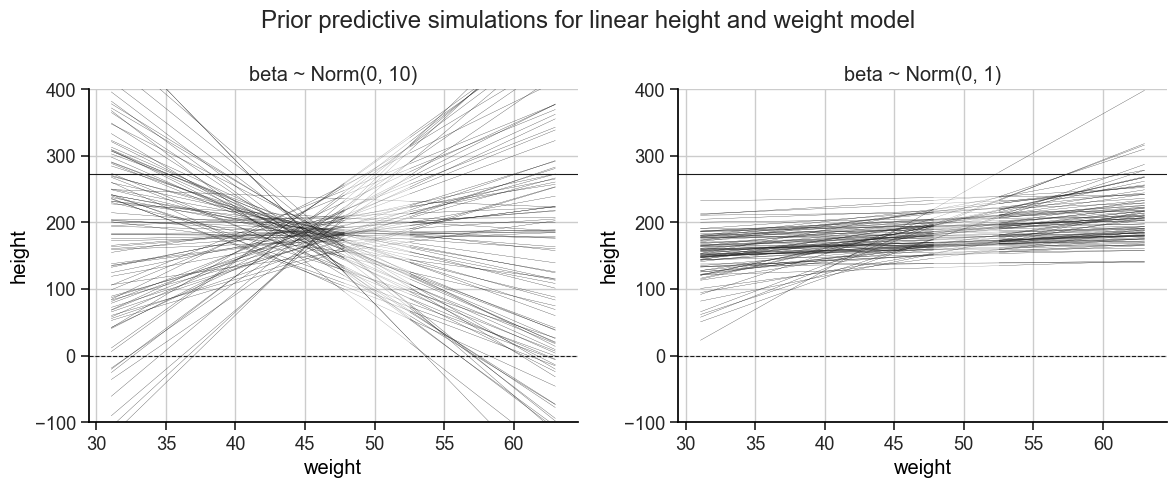

In [24]:
fig, (ax0, ax1) = plt.subplots(ncols=2, figsize=(12, 5))

alpha_prior = stats.norm(loc=178, scale=20)
beta_prior_0 = stats.norm(loc=0, scale=10)
beta_prior_1 = stats.lognorm(s=1)

plot_linear_weight_model_prior_predictive_manual(
    adult, alpha_prior, beta_prior_0, ax=ax0
)
plot_linear_weight_model_prior_predictive_manual(
    adult, alpha_prior, beta_prior_1, ax=ax1
)

ax0.set(title="beta ~ Norm(0, 10)")
ax1.set(title="beta ~ Norm(0, 1)")

fig.suptitle("Prior predictive simulations for linear height and weight model")
plt.tight_layout();

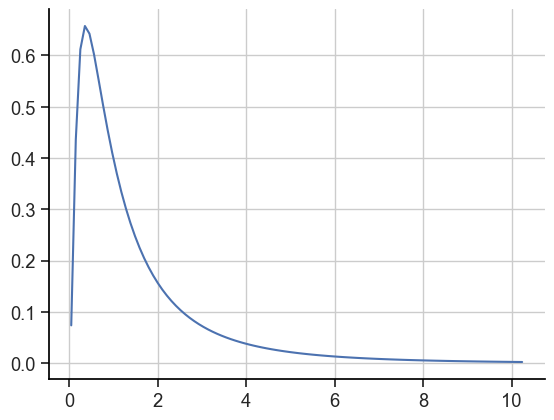

In [25]:
x_plot = np.linspace(beta_prior_1.ppf(0.001), beta_prior_1.ppf(0.99), 100)
y_plot = beta_prior_1.pdf(x_plot)
plt.plot(x_plot, y_plot);

We can do this in PyMC instead.

Sampling: [alpha, beta, height, sigma]
Sampling: [alpha, beta, height, sigma]


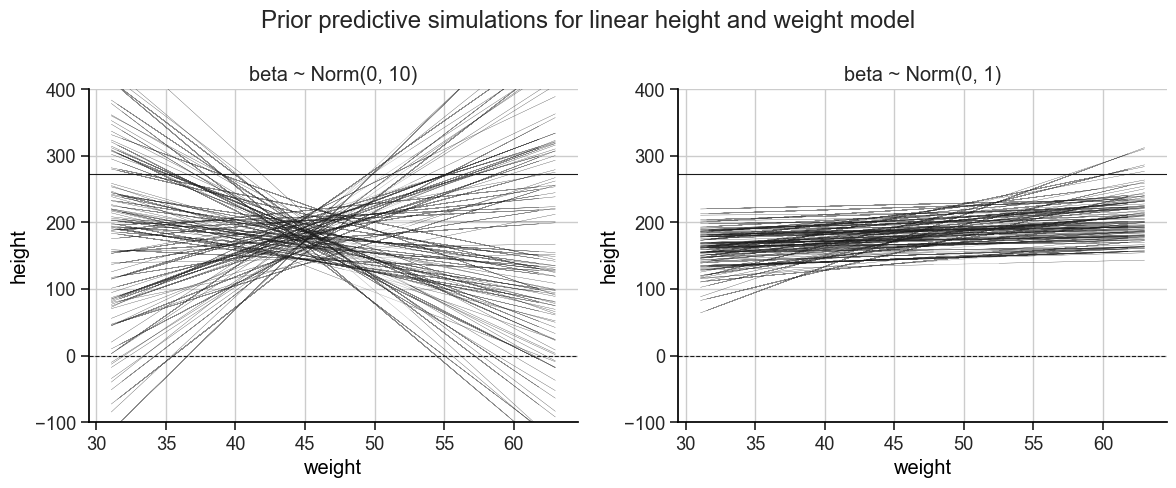

In [27]:
fig, (ax0, ax1) = plt.subplots(ncols=2, figsize=(12, 5))

alpha_prior_kwargs = {"mu": 178, "sigma": 20}
beta_prior_kwargs_0 = {"mu": 0, "sigma": 10}
beta_prior_kwargs_1 = {"mu": 0, "sigma": 1}

plot_linear_weight_model_prior_predictive_pymc(
    adult, alpha_prior_kwargs, beta_prior_kwargs_0, ax=ax0
)
plot_linear_weight_model_prior_predictive_pymc(
    adult, alpha_prior_kwargs, beta_prior_kwargs_1, beta_prior_dist="log_norm", ax=ax1
)

ax0.set(title="beta ~ Norm(0, 10)")
ax1.set(title="beta ~ Norm(0, 1)")

fig.suptitle("Prior predictive simulations for linear height and weight model")
plt.tight_layout();

### 4.4.2 Finding the posterior distribution

In [28]:
# reload the data
howell = load_data(HOWELL_FILE, delimiter=";")
adult = howell.loc[howell["age"] >= 18, :]

Specify the model and sample the posterior

In [29]:
with pm.Model() as m4_3:
    # priors
    alpha = pm.Normal("alpha", mu=178, sigma=20)
    beta = pm.LogNormal("beta", mu=0, sigma=1)
    sigma = pm.Uniform("sigma", lower=0, upper=50)

    # data
    weight = pm.MutableData("weight", adult.weight)

    # deterministic
    mu = pm.Deterministic("mu", alpha + beta * (weight - weight.mean()))

    # observed
    height = pm.Normal("height", mu=mu, sigma=sigma, observed=adult.height)

    # sample posterior
    trace_4_3 = pm.sample(1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [alpha, beta, sigma]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 1 seconds.


### 4.4.3 Interpreting the posterior distribution

Summarise the posterior distributions

In [30]:
az.summary(
    trace_4_3,
    var_names=["alpha", "beta", "sigma"],
    kind="stats",
    hdi_prob=0.89,
    round_to=2,
)

mean    sd  hdi_5.5%  hdi_94.5%
alpha  154.6  0.27    154.17     155.01
beta     0.9  0.04      0.84       0.97
sigma    5.1  0.19      4.78       5.40

Get covariance. Annoying we have to remove the extra dimensions coming from weight and mu.

In [31]:
trace_df = trace_4_3.posterior.drop("mu").mean(dim=["mu_dim_0"]).to_dataframe()
trace_df

alpha      beta     sigma
chain draw                                
0     0     154.967115  0.914691  5.135186
      1     154.967115  0.914691  5.135186
      2     154.351205  0.915040  4.989814
      3     155.073117  0.935043  5.374586
      4     154.633251  0.918451  4.878621
...                ...       ...       ...
3     995   154.480233  0.870321  5.423861
      996   154.778410  0.943066  5.222937
      997   154.227077  0.893322  5.290290
      998   154.387600  0.888576  5.129728
      999   154.795949  0.920807  5.079844

[4000 rows x 3 columns]

Note that this is actually 1000 draws from 4 different chains. We could restrict to a single chain, but it doesn't really matter.

In [32]:
trace_df.cov().round(3)

alpha   beta  sigma
alpha  0.074 -0.000 -0.003
beta  -0.000  0.002 -0.000
sigma -0.003 -0.000  0.037

Now plot the regression line arising from the posterior means

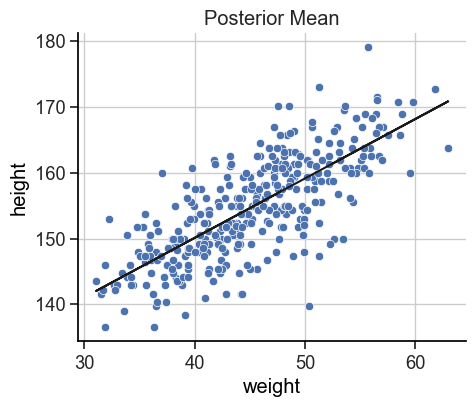

In [33]:
fig, ax = plt.subplots(figsize=(5, 4))

# plot data
sns.scatterplot(adult, x="weight", y="height", ax=ax)

alpha_mean = trace_4_3.posterior.alpha.mean().item(0)
beta_mean = trace_4_3.posterior.beta.mean().item(0)

weight = trace_4_3.constant_data.weight
height_est = alpha_mean + beta_mean * (weight - weight.mean())

ax.plot(weight, height_est, color="k")

ax.set(title="Posterior Mean");

Now sample the posterior and plot the resulting lines against the actual data.

In [34]:
def plot_posterior_lines(adult, n_samples=None, n_lines=20, ax=None):
    if not n_samples:
        n_samples = adult.shape[0]

    with pm.Model():
        # priors
        alpha = pm.Normal("alpha", **alpha_prior_kwargs)
        beta = pm.LogNormal("beta", mu=0, sigma=1)
        sigma = pm.Uniform("sigma", lower=0, upper=50)

        # data
        weight = pm.MutableData("weight", adult.weight.iloc[:n_samples])
        weight_scaled = pm.Deterministic("weight_scaled", weight - weight.mean())

        # deterministic
        mu = pm.Deterministic("mu", alpha + beta * weight_scaled)

        # observed
        height = pm.Normal(
            "height", mu=mu, sigma=sigma, observed=adult.height.iloc[:n_samples]
        )

        # sample posterior
        trace = pm.sample(1000)

    if not ax:
        fig, ax = plt.subplots(figsize=(6, 4))

    # plot data
    sns.scatterplot(adult.iloc[:n_samples], x="weight", y="height", ax=ax)

    for draw in range(n_lines):
        ax.plot(
            trace.constant_data.weight,
            trace.posterior.mu.sel(chain=0, draw=draw),
            color="k",
            lw=0.2,
            alpha=0.5,
        )

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [alpha, beta, sigma]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 1 seconds.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [alpha, beta, sigma]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 1 seconds.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [alpha, beta, sigma]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 1 seconds.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [alpha, beta, sigma]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 1 seconds.


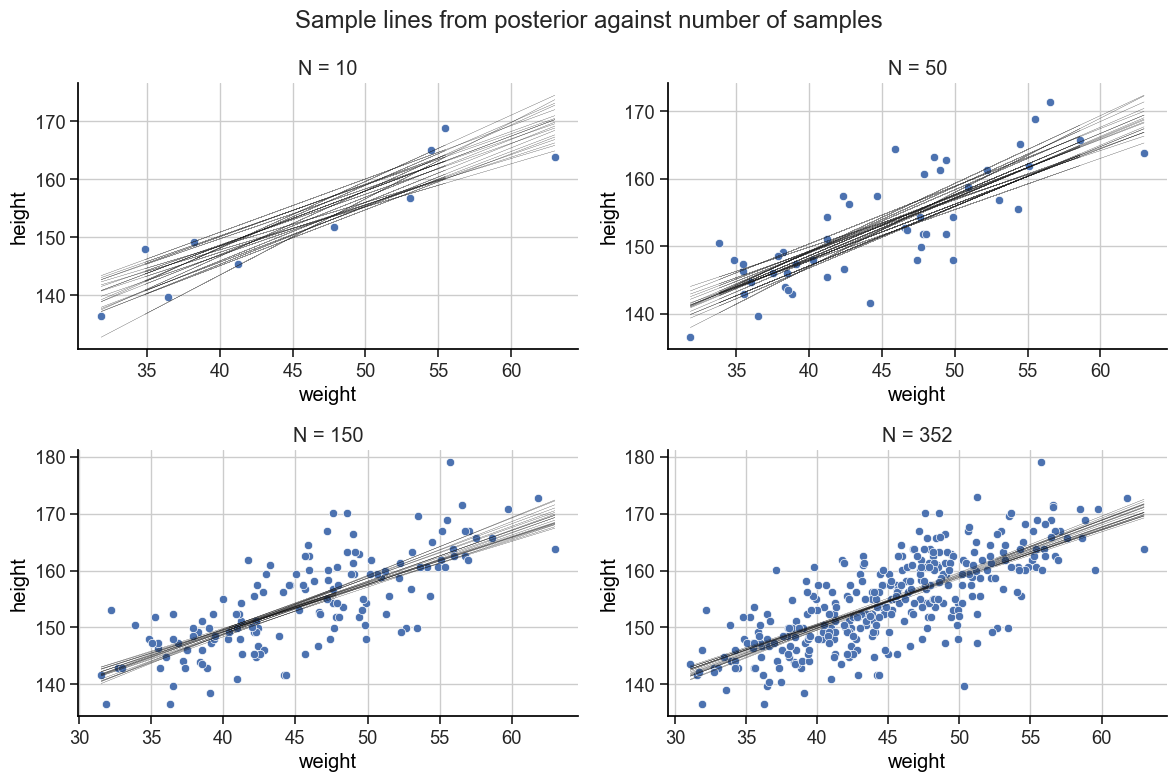

In [35]:
fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(12, 8))

n_samples_list = [10, 50, 150, 352]

axs_ravel = axs.ravel()
for n_samples, ax in zip(n_samples_list, axs_ravel):
    plot_posterior_lines(adult, n_samples=n_samples, ax=ax)
    ax.set(title=f"N = {n_samples}")

fig.suptitle("Sample lines from posterior against number of samples")
fig.tight_layout();

Let's plot the distribution of $\mu$ for fixed weight=50

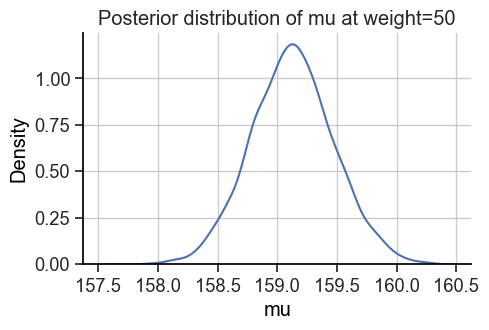

In [36]:
# combine everything into a single sample for each param
data_4_3 = az.extract(trace_4_3)

# calculate mu
weight = trace_4_3.constant_data.weight
mu_at_50 = data_4_3.alpha + data_4_3.beta * (50 - weight.mean())

# plot
fig, ax = plt.subplots(figsize=(5, 3))

sns.kdeplot(mu_at_50, ax=ax)

ax.set(xlabel="mu", title="Posterior distribution of mu at weight=50");

In [37]:
# percentile interval
print(az.hdi(mu_at_50.values, hdi_prob=0.89).round(2))

[158.56 159.67]


We can also plot a HDI around the regression line

In [38]:
mu_hdi = az.hdi(trace_4_3.posterior.mu, hdi_prob=0.89)
mu_hdi

<xarray.Dataset>
Dimensions:   (mu_dim_0: 352, hdi: 2)
Coordinates:
  * mu_dim_0  (mu_dim_0) int64 0 1 2 3 4 5 6 7 ... 345 346 347 348 349 350 351
  * hdi       (hdi) <U6 'lower' 'higher'
Data variables:
    mu        (mu_dim_0, hdi) float64 156.7 157.6 146.1 ... 163.5 160.8 162.1

To get the mean values we can just average over all chains and draws

In [39]:
mu_mean = trace_4_3.posterior.mu.mean(dim=["chain", "draw"])
mu_mean

<xarray.DataArray 'mu' (mu_dim_0: 352)>
array([157.16326211, 146.92157349, 142.74808538, 161.87443887,
       151.24868693, 170.86152063, 148.50903523, 164.07640192,
       145.46213286, 163.18025417, 159.03237028, 151.19747849,
       146.51190595, 157.04981895, 144.54038089, 157.82897187,
       152.19604313, 148.61145211, 158.21303519, 152.55450223,
       146.02542574, 148.20178457, 145.99982151, 150.3781434 ,
       163.74354704, 147.84332547, 148.73947322, 156.06228058,
       149.04672388, 146.1022384 , 156.77919878, 157.21447055,
       158.59709851, 158.57149429, 165.04936234, 149.30276609,
       159.03237028, 151.22308271, 148.79068166, 152.26305467,
       154.29558929, 166.89286629, 156.16469747, 153.91152597,
       159.93994079, 163.02662884, 155.42217504, 157.34249166,
       161.13191645, 156.98403256, 155.19173705, 152.27285579,
       146.92157349, 164.48606947, 147.56167903, 157.59853387,
       147.68970014, 156.57436501, 156.6767819 , 165.9455101 ,
       148.22738879, 156.59996923, 152.989774  , 159.36522516,
       149.53320409, 159.74937338, 149.58441253, 146.74234394,
       155.75502992, 152.14483468, 156.98403256, 164.2812357 ,
       157.82897187, 152.63131489, 145.64136241, 165.22859189,
       160.26137291, 156.62557345, 150.94143627, 143.51621202,
...
       160.05653914, 150.78781094, 147.89453391, 160.56862357,
       154.44921462, 153.16900355, 156.16469747, 149.68682942,
       145.3853202 , 149.45639142, 147.79211702, 157.93138875,
       146.12784262, 153.45064998, 157.49611699, 160.0053307 ,
       153.7066922 , 157.49611699, 156.13909325, 164.92134124,
       157.85457609, 157.52172121, 156.85601145, 146.07663418,
       147.02470884, 158.18743097, 160.26137291, 155.98546792,
       147.35684526, 157.90578453, 148.32980567, 156.6767819 ,
       163.99958926, 162.92421195, 157.7521592 , 152.86175289,
       144.84763154, 159.08357872, 154.01394286, 144.18192178,
       156.6767819 , 155.62700881, 156.77919878, 150.86462361,
       159.44203782, 154.73086106, 152.11923046, 151.58154181,
       154.80767373, 160.26137291, 158.46907741, 160.21016447,
       153.57867109, 146.05102996, 152.70146809, 156.21590591,
       151.78637558, 148.46976976, 153.07590143, 162.41212752,
       152.78494022, 149.89166319, 153.1177951 , 161.54158399,
       148.68826478, 152.63131489, 146.38388484, 153.91152597,
       148.3554099 , 153.80910909, 153.73229642, 157.21447055,
       149.55880831, 151.04385316, 150.83901939, 156.4463439 ,
       144.89883999, 161.080708  , 162.79619085, 161.41356288])
Coordinates:
  * mu_dim_0  (mu_dim_0) int64 0 1 2 3 4 5 6 7 ... 345 346 347 348 349 350 351

We need to order by weight in the plot so it's convenient to collect all the data into a dataframe.

In [40]:
mu_plot_data = pd.DataFrame(
    {
        "weight": trace_4_3.constant_data.weight,
        "mean": mu_mean,
        "hdi_lower": mu_hdi.mu.sel(hdi="lower"),
        "hdi_higher": mu_hdi.mu.sel(hdi="higher"),
    }
).sort_values("weight")

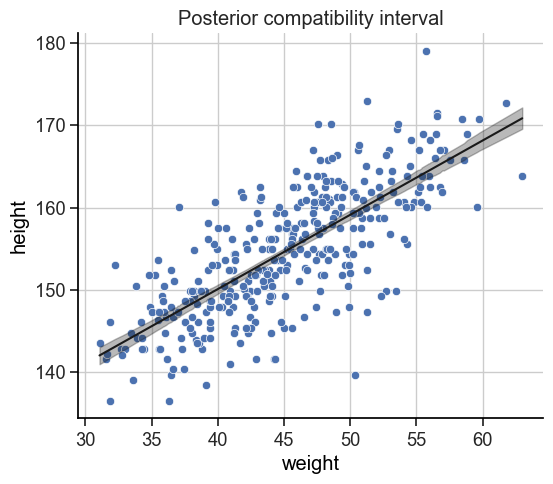

In [41]:
fig, ax = plt.subplots(figsize=(6, 5))

# plot true data
sns.scatterplot(adult.iloc[:n_samples], x="weight", y="height", ax=ax)

# plot the mean at each weight
ax.plot(mu_plot_data["weight"], mu_plot_data["mean"], color="k")

ax.fill_between(
    mu_plot_data["weight"],
    mu_plot_data["hdi_lower"],
    mu_plot_data["hdi_higher"],
    color="k",
    alpha=0.3,
)

ax.set(title="Posterior compatibility interval");

We add in the uncertainty coming from $\mu$ by taking a posterior predictive sample and constructing an HDI at each weight value

In [42]:
with m4_3:
    post_pred_sample = pm.sample_posterior_predictive(trace_4_3)

Sampling: [height]


In [43]:
height_hdi = az.hdi(post_pred_sample.posterior_predictive.height, hdi_prob=0.89)
post_pred_plot_data = pd.DataFrame(
    {
        "weight": trace_4_3.constant_data.weight,
        "hdi_lower": height_hdi.height.sel(hdi="lower"),
        "hdi_higher": height_hdi.height.sel(hdi="higher"),
    }
).sort_values("weight")

Now add this to the plot above

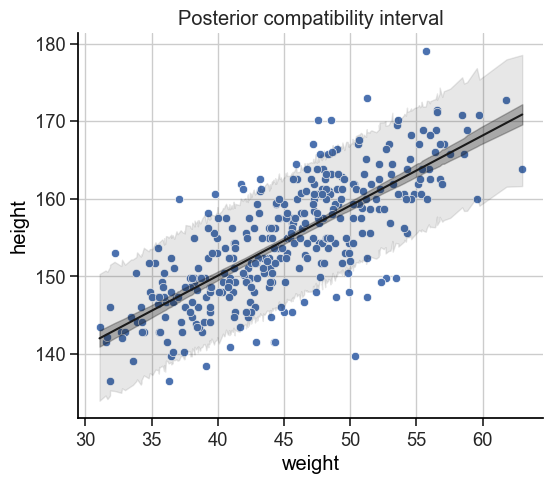

In [44]:
fig, ax = plt.subplots(figsize=(6, 5))

# plot true data
sns.scatterplot(adult.iloc[:n_samples], x="weight", y="height", ax=ax)

# plot the mean at each weight
ax.plot(mu_plot_data["weight"], mu_plot_data["mean"], color="k")

# mu HDI
ax.fill_between(
    mu_plot_data["weight"],
    mu_plot_data["hdi_lower"],
    mu_plot_data["hdi_higher"],
    color="k",
    alpha=0.3,
)

# posterior predictive HDI
ax.fill_between(
    post_pred_plot_data["weight"],
    post_pred_plot_data["hdi_lower"],
    post_pred_plot_data["hdi_higher"],
    color="k",
    alpha=0.1,
)

ax.set(title="Posterior compatibility interval");

## 4.5 Curves from lines

### 4.5.1 Polynomial regression

Plot the full height and weight data

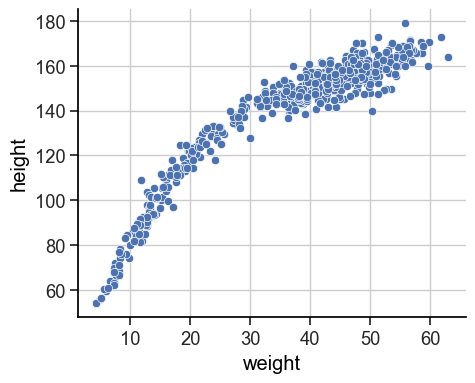

In [45]:
# reload the data
howell = load_data(HOWELL_FILE, delimiter=";")

# plot
fig, ax = plt.subplots(figsize=(5, 4))
sns.scatterplot(howell, x="weight", y="height", ax=ax);

Standardise weight and add polynomial features

In [46]:
# standardise weight
howell["weight_std"] = (howell["weight"] - howell["weight"].mean()) / howell[
    "weight"
].std()
howell["weight_std_sq"] = howell["weight_std"] ** 2
howell["weight_std_cub"] = howell["weight_std"] ** 3

In [47]:
with pm.Model() as m4_5:
    # priors
    alpha = pm.Normal("alpha", mu=178, sigma=20)
    beta1 = pm.LogNormal("beta1", mu=0, sigma=1)
    beta2 = pm.Normal("beta2", mu=0, sigma=1)
    sigma = pm.Uniform("sigma", lower=0, upper=50)

    # data
    weight = pm.MutableData("weight", howell.weight)
    weight_std = pm.MutableData("weight_std", howell.weight_std)
    weight_std_sq = pm.MutableData("weight_std_sq", howell.weight_std_sq)

    # deterministic
    mu = pm.Deterministic("mu", alpha + beta1 * weight_std + beta2 * weight_std_sq)

    # observed
    height = pm.Normal("height", mu=mu, sigma=sigma, observed=howell.height)

    # sample posterior
    trace_4_5 = pm.sample(1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [alpha, beta1, beta2, sigma]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 2 seconds.


In [48]:
az.summary(
    trace_4_5,
    var_names="~mu",
    filter_vars="regex",
    kind="stats",
    hdi_prob=0.89,
    round_to=2,
)

mean    sd  hdi_5.5%  hdi_94.5%
alpha  146.04  0.36    145.47     146.61
beta2   -7.79  0.27     -8.22      -7.35
beta1   21.75  0.29     21.27      22.19
sigma    5.80  0.18      5.55       6.12

Now we plot the mean and a posterior predictive HDI against the data.

In [49]:
def plot_mean_and_posterior_predictive_hdi(model, data, ax=None):
    with model:
        # sample posterior
        trace = pm.sample(1000)

        # sample posterior predictive
        pp_trace = pm.sample_posterior_predictive(trace)

    # get mean of mu
    mu_mean = pd.Series(
        index=trace.constant_data.weight,
        data=trace.posterior.mu.mean(dim=["chain", "draw"]),
    ).sort_index()

    # get posterior predictive hdi
    height_hdi = az.hdi(pp_trace.posterior_predictive.height, hdi_prob=0.89)
    height_hdi = pd.DataFrame(
        {
            "weight": trace.constant_data.weight,
            "hdi_lower": height_hdi.height.sel(hdi="lower"),
            "hdi_higher": height_hdi.height.sel(hdi="higher"),
        }
    ).sort_values("weight")

    # plot
    if not ax:
        fig, ax = plt.subplots(figsize=(6, 5))

    # plot true data
    sns.scatterplot(data, x="weight", y="height", ax=ax)

    # plot the mean at each weight
    ax.plot(mu_mean, color="k")

    # posterior predictive HDI
    ax.fill_between(
        height_hdi["weight"],
        height_hdi["hdi_lower"],
        height_hdi["hdi_higher"],
        color="k",
        alpha=0.1,
    )

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [alpha, beta1, beta2, sigma]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 1 seconds.
Sampling: [height]


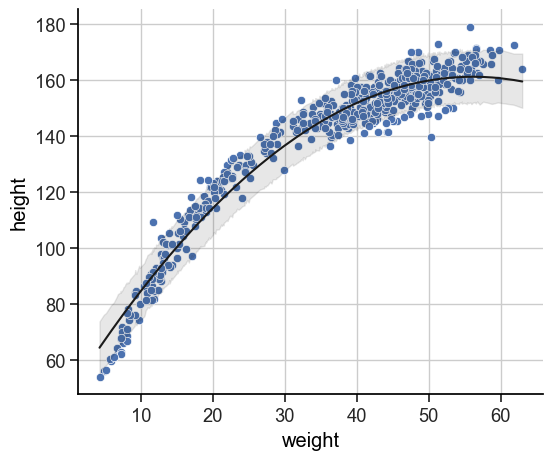

In [50]:
plot_mean_and_posterior_predictive_hdi(m4_5, howell)

In [51]:
# linear model
with pm.Model() as m4_4:
    # priors
    alpha = pm.Normal("alpha", mu=178, sigma=20)
    beta1 = pm.LogNormal("beta1", mu=0, sigma=1)
    sigma = pm.Uniform("sigma", lower=0, upper=50)

    # data
    weight = pm.MutableData("weight", howell.weight)
    weight_std = pm.MutableData("weight_std", howell.weight_std)

    # deterministic
    mu = pm.Deterministic("mu", alpha + beta1 * weight_std)

    # observed
    height = pm.Normal("height", mu=mu, sigma=sigma, observed=howell.height)


# cubic model
with pm.Model() as m4_6:
    # priors
    alpha = pm.Normal("alpha", mu=178, sigma=20)
    beta1 = pm.LogNormal("beta1", mu=0, sigma=1)
    beta2 = pm.Normal("beta2", mu=0, sigma=1)
    beta3 = pm.Normal("beta3", mu=0, sigma=1)
    sigma = pm.Uniform("sigma", lower=0, upper=50)

    # data
    weight = pm.MutableData("weight", howell.weight)
    weight_std = pm.MutableData("weight_std", howell.weight_std)
    weight_std_sq = pm.MutableData("weight_std_sq", howell.weight_std_sq)
    weight_std_cub = pm.MutableData("weight_std_cub", howell.weight_std_cub)

    # deterministic
    mu = pm.Deterministic(
        "mu",
        alpha + beta1 * weight_std + beta2 * weight_std_sq + beta3 * weight_std_cub,
    )

    # observed
    height = pm.Normal("height", mu=mu, sigma=sigma, observed=howell.height)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [alpha, beta1, sigma]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 1 seconds.
Sampling: [height]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [alpha, beta1, beta2, sigma]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 2 seconds.
Sampling: [height]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [alpha, beta1, beta2, beta3, sigma]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 3 seconds.
Sampling: [height]


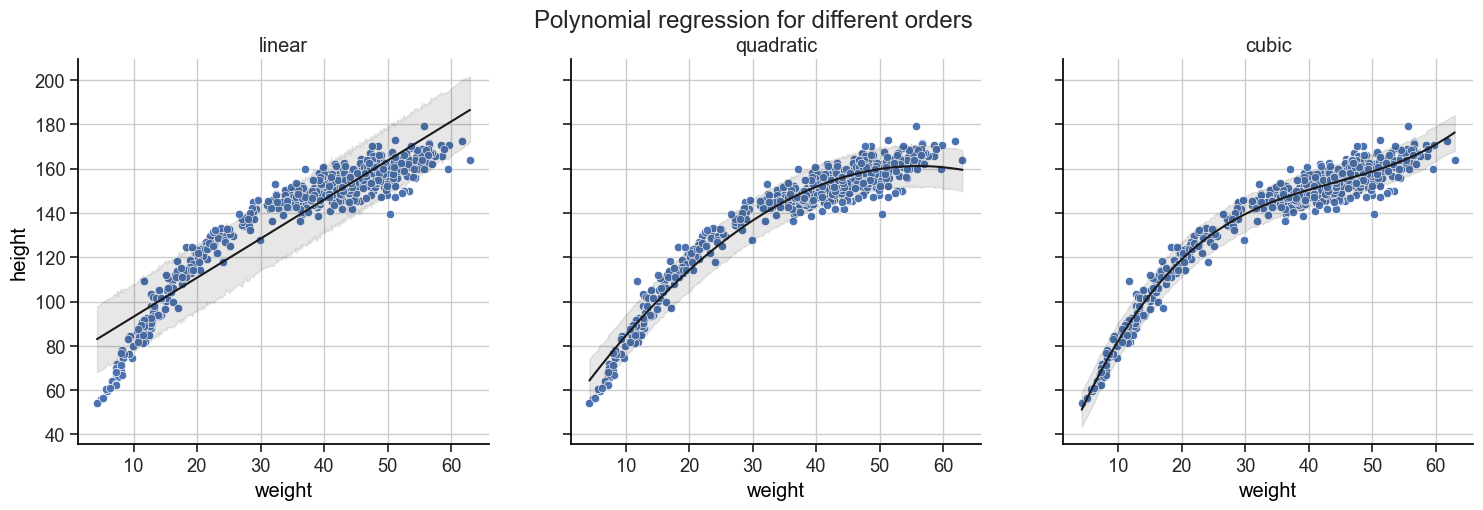

In [52]:
fig, axs = plt.subplots(ncols=3, sharey=True, figsize=(18, 5))

models = {
    "linear": m4_4,
    "quadratic": m4_5,
    "cubic": m4_6,
}
for ax, (name, model) in zip(axs, models.items()):
    plot_mean_and_posterior_predictive_hdi(model, howell, ax=ax)
    ax.set(title=name)

fig.suptitle("Polynomial regression for different orders");

### 4.5.2 Splines

Load the data

In [53]:
cherry = load_data(CHERRY_BLOSSOMS_FILE)

# drop rows missing doy data
cherry = cherry.dropna(subset=["doy"])

cherry.describe()

year         doy        temp  temp_upper  temp_lower
count   827.000000  827.000000  787.000000  787.000000  787.000000
mean   1548.841596  104.540508    6.100356    6.937560    5.263545
std     304.149774    6.407036    0.683410    0.811986    0.762194
min     812.000000   86.000000    4.690000    5.450000    2.610000
25%    1325.000000  100.000000    5.625000    6.380000    4.770000
50%    1583.000000  105.000000    6.060000    6.800000    5.250000
75%    1803.500000  109.000000    6.460000    7.375000    5.650000
max    2015.000000  124.000000    8.300000   12.100000    7.740000

Plot `doy` against year

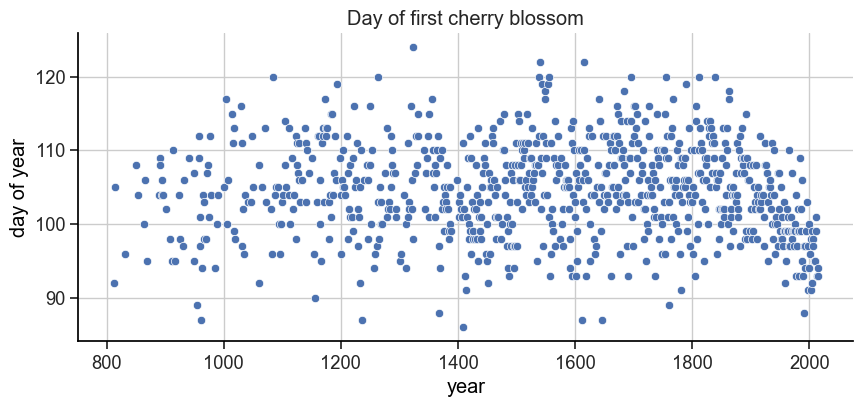

In [54]:
fig, ax = plt.subplots(figsize=(10, 4))

sns.scatterplot(cherry, x="year", y="doy", ax=ax)

ax.set(ylabel="day of year", title="Day of first cherry blossom");

Start with linear splines with 5 knots. The matrix with each basis spline evaluated at each data point is called the 'design matrix'

In [55]:
def generate_design_matrix(cherry, n_knots, deg):
    knots = np.quantile(cherry.year, np.linspace(0, 1, n_knots))

    # add additional endpoint control knots - deg at each endpoint
    start_knots = np.array([cherry.year.min()] * deg)
    end_knots = np.array([cherry.year.max()] * deg)
    knots_ext = np.concatenate([start_knots, knots, end_knots])

    # this brings total knots to n_knots + 2 * deg, so we will have
    n_basis = n_knots + deg - 1

    # use arbitrary weights to start
    splines = BSpline(knots_ext, np.ones(n_basis), deg)

    # design matrix is basis splines evaluated at given points
    design_matrix = splines.design_matrix(
        cherry.year, knots_ext, deg, extrapolate=True
    ).toarray()

    return design_matrix, knots

In [56]:
n_knots = 5
deg = 1

design_matrix, knots = generate_design_matrix(cherry, n_knots, deg)

We plot the individual (unweighted) basis splines

In [57]:
def plot_basis_splines(cherry, design_matrix, knots, ax=None):
    if not ax:
        fig, ax = plt.subplots(figsize=(10, 3))

    # plot the basis splines
    n_basis = design_matrix.shape[1]
    for i in range(n_basis):
        ax.plot(cherry.year, design_matrix[:, i])

    # plot the knots
    for knot in knots:
        ax.axvline(knot, ls="--", color="k", alpha=0.5)

    ax.set(
        xlabel="year",
        ylabel="basis value",
        title="Basis Splines",
    )

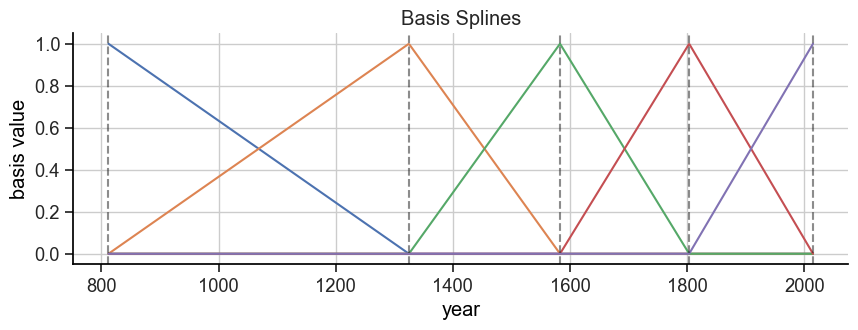

In [58]:
plot_basis_splines(cherry, design_matrix, knots)

Now define a linear model with the basis splines as inputs.

In [59]:
def define_linear_spline_model(cherry, design_matrix, beta_prior_sigma=10):
    n_basis = design_matrix.shape[1]

    with pm.Model() as model:
        # priors
        alpha = pm.Normal("alpha", mu=100, sigma=10)
        beta = pm.Normal("beta", mu=0, sigma=beta_prior_sigma, shape=n_basis)
        sigma = pm.Exponential("sigma", lam=1)

        # data
        year = pm.MutableData("year", cherry.year)
        year_splines = pm.MutableData(
            "year_splines", design_matrix
        )  # shape is inferred

        # deterministic
        mu = pm.Deterministic("mu", alpha + year_splines @ beta)

        # observed
        doy = pm.Normal("doy", mu=mu, sigma=sigma, observed=cherry.doy)

    return model

In [60]:
m4_7a = define_linear_spline_model(cherry, design_matrix)

with m4_7a:
    trace_4_7a = pm.sample(1000)

az.summary(
    trace_4_7a,
    var_names="~mu",
    filter_vars="regex",
    kind="stats",
    hdi_prob=0.89,
    round_to=2,
)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [alpha, beta, sigma]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 7 seconds.


mean    sd  hdi_5.5%  hdi_94.5%
alpha    103.12  4.22     96.33     109.45
beta[0]   -0.01  4.32     -6.34       7.09
beta[1]    1.85  4.25     -4.58       8.74
beta[2]    1.89  4.25     -4.71       8.62
beta[3]    4.34  4.26     -2.14      11.23
beta[4]   -5.26  4.26    -11.55       1.84
sigma      6.09  0.15      5.86       6.32

We can plot the weighted splines by finding the MAP for the spline weights.

In [61]:
def plot_weighted_splines(model, cherry, knots, ax=None):
    with model:
        trace = pm.sample(1000)
        map = pm.find_MAP()

    if not ax:
        fig, ax = plt.subplots(figsize=(10, 3))

    # plot each of the weighted basis splines
    weighted_splines = trace.constant_data["year_splines"].values * map["beta"]
    n_basis = weighted_splines.shape[1]
    for i in range(n_basis):
        ax.plot(cherry.year, weighted_splines[:, i])

    # plot the knot locations
    for knot in knots:
        ax.axvline(knot, ls="--", color="k", alpha=0.5)

    # plot the combination of them all
    ax.plot(cherry.year, weighted_splines.sum(axis=1), color="k")

    ax.set(
        xlabel="year",
        ylabel="basis * weight",
        title="Weighted basis splines",
    )

    return trace

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [alpha, beta, sigma]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 7 seconds.


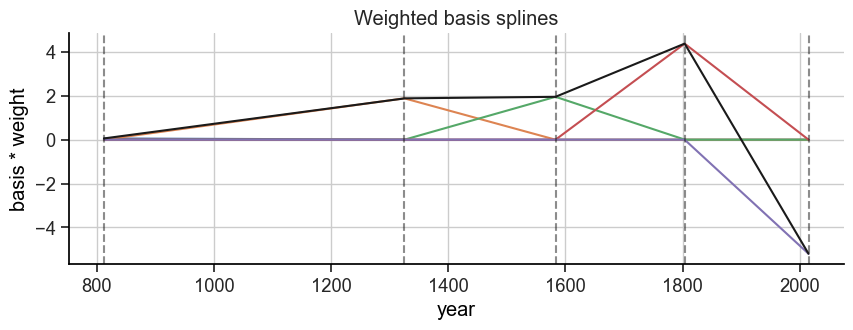

In [62]:
plot_weighted_splines(m4_7a, cherry, knots);

Finally we find the posterior mean and a HDI for mu and plot it alongside the original data

In [63]:
def plot_splines_mean_and_posterior_hdi(trace, cherry, hdi_prob=0.89, ax=None):
    mu_mean = trace.posterior.mu.mean(dim=["chain", "draw"])
    mu_hdi = az.hdi(trace.posterior.mu, hdi_prob=0.89)

    mu_plot_data = pd.DataFrame(
        {
            "year": trace.constant_data.year,
            "mean": mu_mean,
            "hdi_lower": mu_hdi.mu.sel(hdi="lower"),
            "hdi_higher": mu_hdi.mu.sel(hdi="higher"),
        }
    ).sort_values("year")

    if not ax:
        fig, ax = plt.subplots(figsize=(10, 4))

    # plot true data
    sns.scatterplot(cherry, x="year", y="doy", ax=ax)

    # plot the mean estimates
    ax.plot(mu_plot_data["year"], mu_plot_data["mean"], color="k")

    # posterior HDI
    ax.fill_between(
        mu_plot_data["year"],
        mu_plot_data["hdi_lower"],
        mu_plot_data["hdi_higher"],
        color="k",
        alpha=0.5,
    )

    ax.set(ylabel="Day of year", title="Day of first cherry blossom");

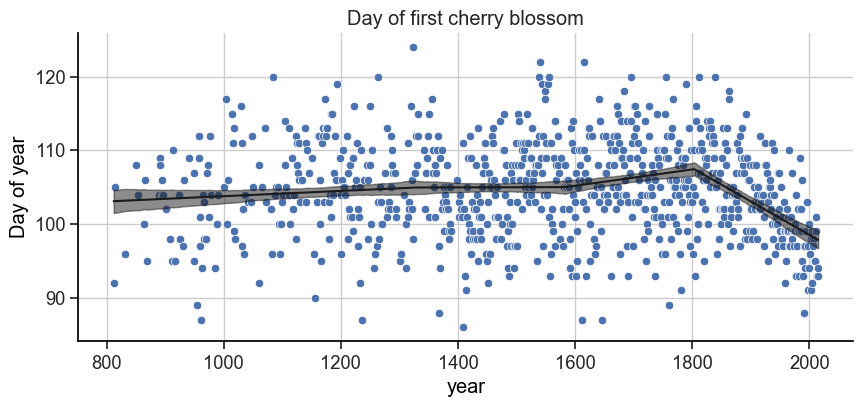

In [64]:
plot_splines_mean_and_posterior_hdi(trace_4_7a, cherry)

Now let's repeat that with different numbers of splines and knots.

In [65]:
def fit_and_plot_spline_model(cherry, n_knots, deg, beta_prior_sigma=10):
    fig, axs = plt.subplots(nrows=3, sharex=True, figsize=(9, 9))

    design_matrix, knots = generate_design_matrix(cherry, n_knots, deg)
    plot_basis_splines(cherry, design_matrix, knots, ax=axs[0])

    # get the model
    model = define_linear_spline_model(cherry, design_matrix, beta_prior_sigma)
    trace = plot_weighted_splines(model, cherry, knots, ax=axs[1])

    # plot the predictions
    plot_splines_mean_and_posterior_hdi(trace, cherry, ax=axs[2])

    for ax in axs:
        ax.set(xlabel=None, title=None)

    axs[2].set(xlabel="year")

    fig.suptitle(f"Degree {deg} basis splines with {n_knots} knots")
    plt.tight_layout()
    
    
    return model, trace

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [alpha, beta, sigma]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 6 seconds.


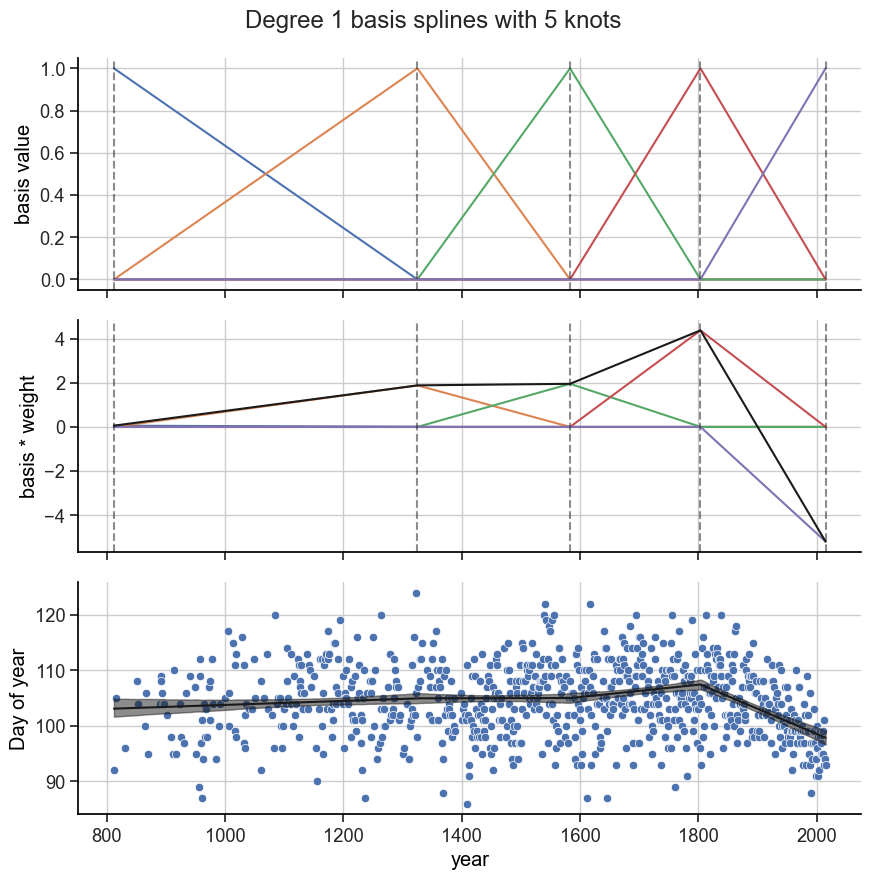

In [66]:
fit_and_plot_spline_model(cherry, n_knots=5, deg=1);

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [alpha, beta, sigma]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 7 seconds.


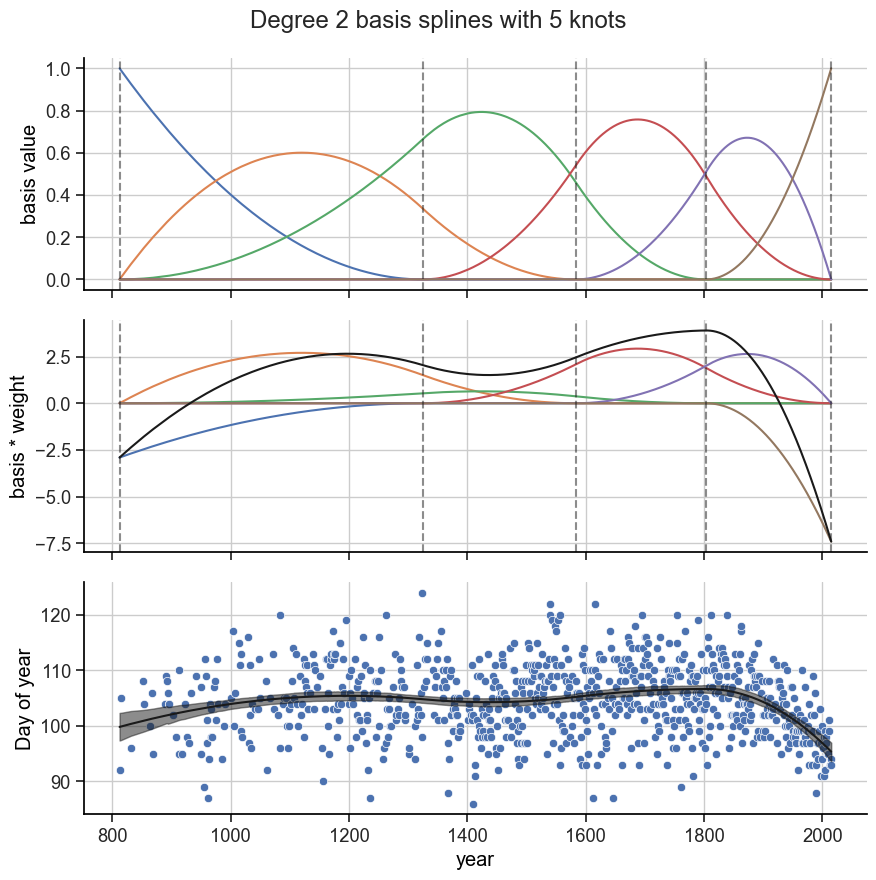

In [67]:
fit_and_plot_spline_model(cherry, n_knots=5, deg=2);

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [alpha, beta, sigma]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 8 seconds.


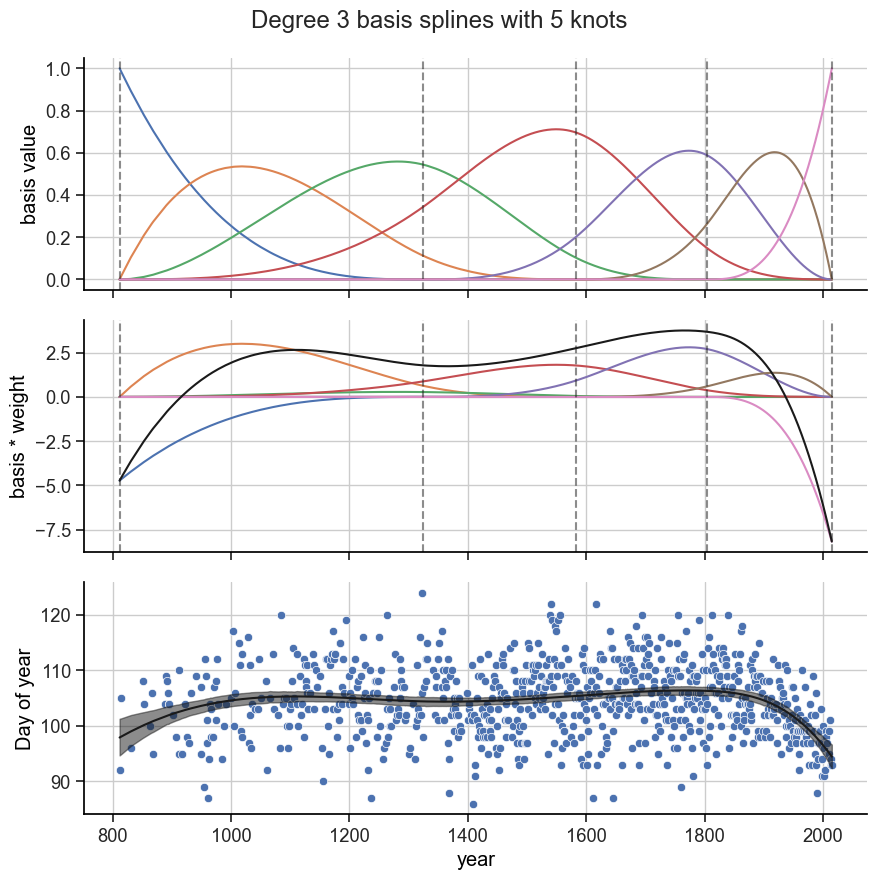

In [68]:
fit_and_plot_spline_model(cherry, n_knots=5, deg=3);

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [alpha, beta, sigma]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 9025 seconds.


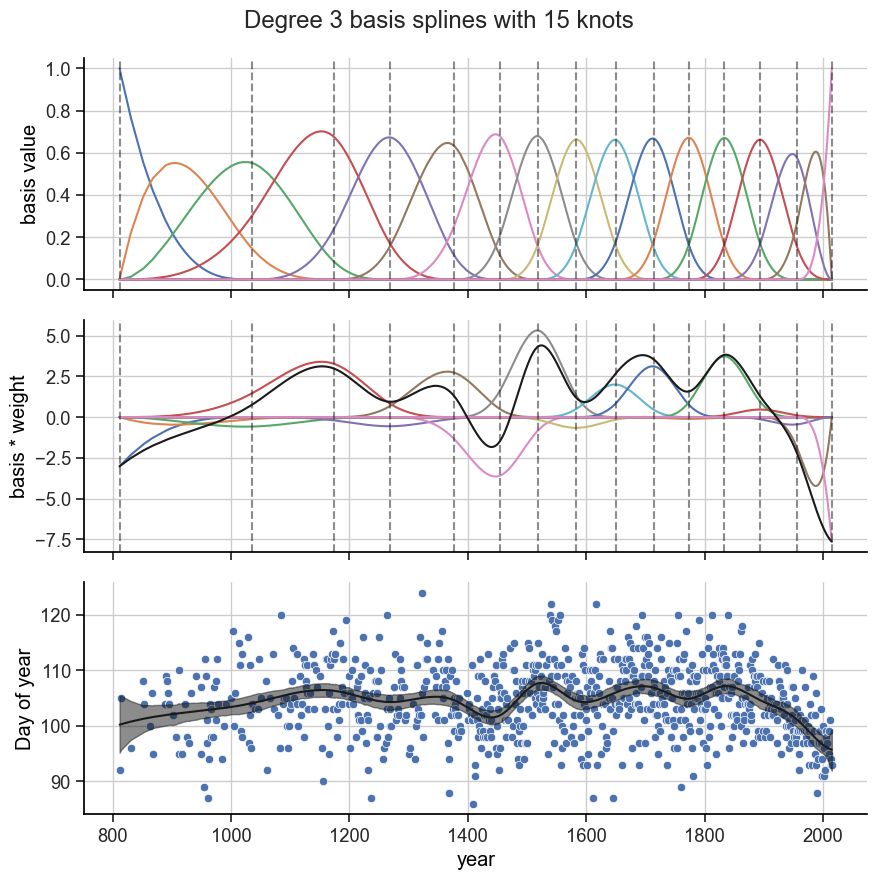

In [69]:
model, trace = fit_and_plot_spline_model(cherry, n_knots=15, deg=3)

# Exercises

## Easy

### 4E1

In the model definition below, which line is the likelihood?

\begin{align}
    y_i & \sim \text{Normal}\left( \mu, \sigma\right) \\
    \mu & \sim \text{Normal}\left( 0, 10\right) \\
    \sigma & \sim \text{Exponential}\left( 1\right).
\end{align}

---

The first line.

### 4E2

In the model definition just above, how many parameters are in the posterior distribution.

---

Two: $\mu$ and $\sigma$.

### 4E3

Using the model definition above, write down the appropriate form of Bayes' theorem that includes the proper likelihood and priors.

---

\begin{equation}
    \text{P}(\mu, \sigma \mid y) = \frac{
        \prod_i \text{Normal}(y_i\mid \mu, \sigma) ~\text{Normal}(\mu \mid 0, 10) ~\text{Exponential}(\sigma \mid 1)
    }{
        \int\int \prod_i \text{Normal}(y_i\mid\mu, \sigma) ~\text{Normal}(\mu \mid 0, 10) ~\text{Exponential}(\sigma \mid 1) \,\mathrm{d}\mu \,\mathrm{d}\sigma 
    }
\end{equation}

### 4E4

In the model definition below, which line is the linear model?

\begin{align}
    y_i & \sim \text{Normal}(\mu, \sigma) \\
    \mu_i & = \alpha + \beta x_i \\
    \alpha & \sim \text{Normal}(0, 10) \\
    \beta & \sim \text{Normal}(0, 1) \\
    \sigma & \sim \text{Exponential}(2) \\
\end{align}

---

The second.

### 4E5

In the model definition just above, how many parameters are in the posterior distribution?

---

Three.

## Medium

### 4M1

For the model definition below, simulate observed $y$ values from the prior (not the posterior).

\begin{align}
    y_i & \sim \text{Normal}\left( \mu, \sigma\right) \\
    \mu & \sim \text{Normal}\left( 0, 10\right) \\
    \sigma & \sim \text{Exponential}\left( 1\right).
\end{align}

---

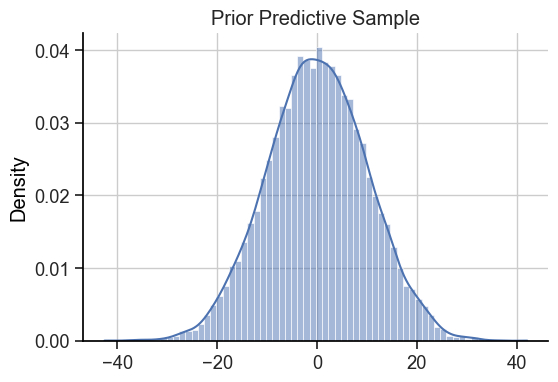

In [14]:
n_sample = 10000

# priors
mu_prior = stats.norm(loc=0, scale=10)
lam = 1
sigma_prior = stats.expon(scale=1/lam)

# sample priors
mu_sample = mu_prior.rvs(n_sample)
sigma_sample = sigma_prior.rvs(n_sample)

# sample likelihood
prior_pred_sample = stats.norm.rvs(loc=mu_sample, scale=sigma_sample, size=n_sample)

# plot distribution
fig, ax = plt.subplots(figsize=(6, 4))

sns.histplot(prior_pred_sample, stat="density", kde=True, ax=ax)

ax.set(title="Prior Predictive Sample");

### 4M2

Translate the model just above into a quap formula.

---

Skipped, not relevant in Python.

### 4M3

Translate the quap model formula below into a mathematical model definition.

```
y ~ dnorm( mu , sigma ),
mu <- a + b*x,
a ~ dnorm( 0 , 10 ),
b ~ dunif( 0 , 1 ),
sigma ~ dexp( 1 )
```

---

I assume that this means

\begin{align}
    y_i & \sim \text{Normal}(\mu, \sigma) \\
    \mu_i & = \alpha + \beta x_i \\
    \alpha & \sim \text{Normal}(0, 10) \\
    \beta & \sim \text{Normal}(0, 1) \\
    \sigma & \sim \text{Exponential}(1). \\
\end{align}

### 4M4

A sample of students is measured for height each year for 3 years.
After the third year, you want to fit a linear regression predicting height using year as a predictor.
Write down the mathematical model definition for this regression, using any variable names and priors you choose.
Be prepared to defend your choice of priors.

---

Using $h$ to denote height and $t$ to denote years since first measurement, I would use the following model:

\begin{align}
    h_i & \sim \text{Normal}(\mu, \sigma) \\
    \mu_i & = \alpha + \beta t_i \\
    \alpha & \sim \text{Normal}(130, 20) \\
    \beta & \sim \text{Normal}(6, 3) \\
    \sigma & \sim \text{Exponential}(0.2). \\
\end{align}

Now we justify our priors. First let's define them.

In [84]:
# priors
alpha_prior = stats.norm(loc=130, scale=20)
beta_prior = stats.norm(loc=6, scale=3)
lam = 0.2
sigma_prior = stats.expon(scale=1/lam)

First just plot the priors. Note that
- $\alpha$ represents the mean height in the first year
- $\beta$ represents the mean yearly change
- $\sigma$ represents the standard deviation between students in a given year

In [98]:
def plot_child_height_against_time_priors(alpha_prior, beta_prior, sigma_prior, n_sample):
    # sample priors for plot
    alpha_sample = alpha_prior.rvs(n_sample)
    beta_sample = beta_prior.rvs(n_sample)
    sigma_sample = sigma_prior.rvs(n_sample)

    # plot priors
    fig, axs = plt.subplots(ncols=3, figsize=(12, 4))

    sns.histplot(alpha_sample, stat="density", kde=True, ax=axs[0])
    axs[0].set(
        xlabel="Height (cm)",
        title="alpha",
    )
    sns.histplot(beta_sample, stat="density", kde=True, ax=axs[1])
    axs[1].set(
        xlabel="Height change (cm)",
        ylabel=None,
        title="beta",
    )
    sns.histplot(sigma_sample, stat="density", kde=True, ax=axs[2])
    axs[2].set(
        xlabel="Height(cm)",
        ylabel=None,
        title="sigma",
    )

    fig.suptitle("Priors")
    
    return fig, axs

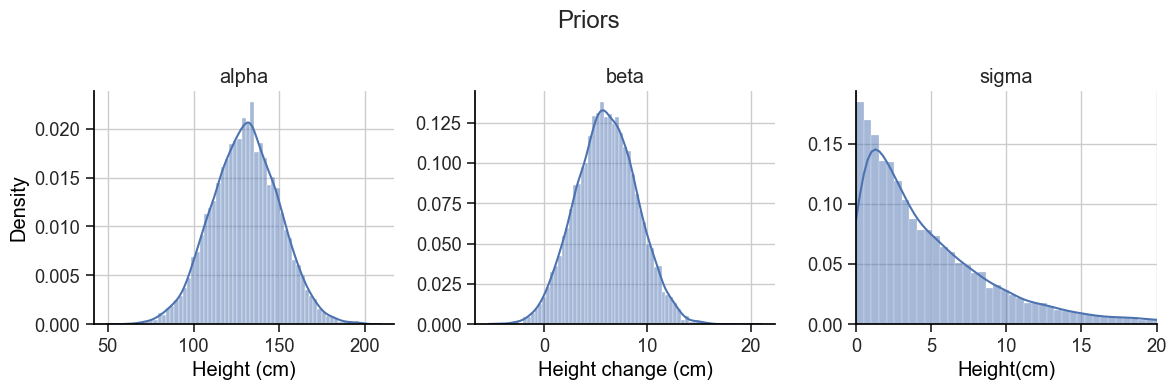

In [99]:
fig, axs = plot_child_height_against_time_priors(alpha_prior, beta_prior, sigma_prior, n_sample=10000)

axs[2].set(xlim=[0, 20])
plt.tight_layout()

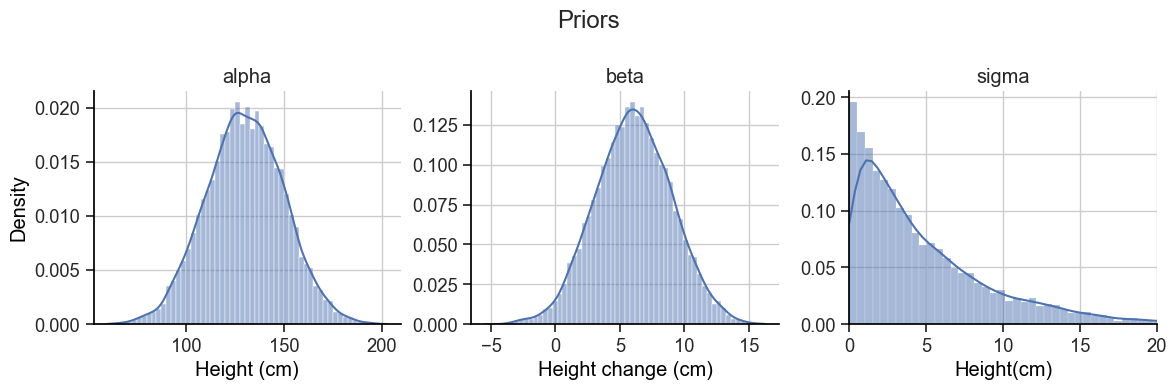

In [70]:
n_sample = 10000

# sample priors for plot
alpha_sample = alpha_prior.rvs(n_sample)
beta_sample = beta_prior.rvs(n_sample)
sigma_sample = sigma_prior.rvs(n_sample)

# plot priors
fig, axs = plt.subplots(ncols=3, figsize=(12, 4))

sns.histplot(alpha_sample, stat="density", kde=True, ax=axs[0])
axs[0].set(
    xlabel="Height (cm)",
    title="alpha",
)
sns.histplot(beta_sample, stat="density", kde=True, ax=axs[1])
axs[1].set(
    xlabel="Height change (cm)",
    ylabel=None,
    title="beta",
)
sns.histplot(sigma_sample, stat="density", kde=True, ax=axs[2])
axs[2].set(
    xlim=[0, 20],
    xlabel="Height(cm)",
    ylabel=None,
    title="sigma",
)

fig.suptitle("Priors")
plt.tight_layout();

These seem reasonable to me:
- We don't know what age the students are but between ages 5 - 16 the mean height of children can vary between 100 and 170 cm
- Height will generally increase by 5-8cm per year during childhood
- Height can reasonably vary between children by 5-10cm.

As a final check we sample the priors and generate a prior predictive distribution for $\mu$. Note that this is the mean by year, and doesn't take the variation due to $\sigma$ into account.

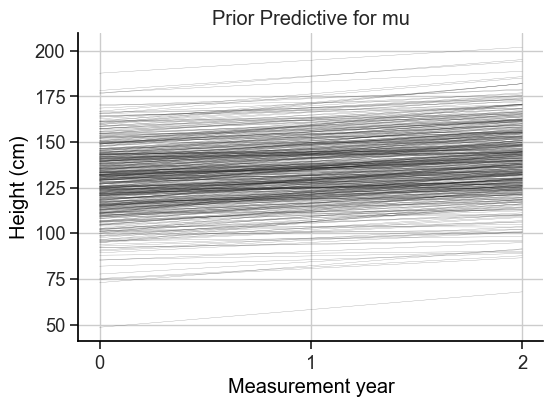

In [74]:
n_sample = 500

# sample priors
alpha_sample = alpha_prior.rvs(n_sample)
beta_sample = beta_prior.rvs(n_sample)

t = np.arange(3)
mu_sample = np.array([alpha_sample + beta_sample * year for year in t])

# plot lines
fig, ax = plt.subplots(figsize=(6, 4))

for sample in range(n_sample):
    ax.plot(t, mu_sample[:, sample], color="k", lw=0.2, alpha=0.5)

ax.set(
    xticks=[0, 1, 2],
    # xticklabels=[0, 1, 2],
    xlabel="Measurement year",
    ylabel="Height (cm)",
    title="Prior Predictive for mu",
);

### 4M5

Now suppose I remind you that every student got taller each year. 
Does this information lead you to change your choice of priors?
How?

---

The prior for beta already had very few negative values, but we could force it to be positive using a gamma distribution.

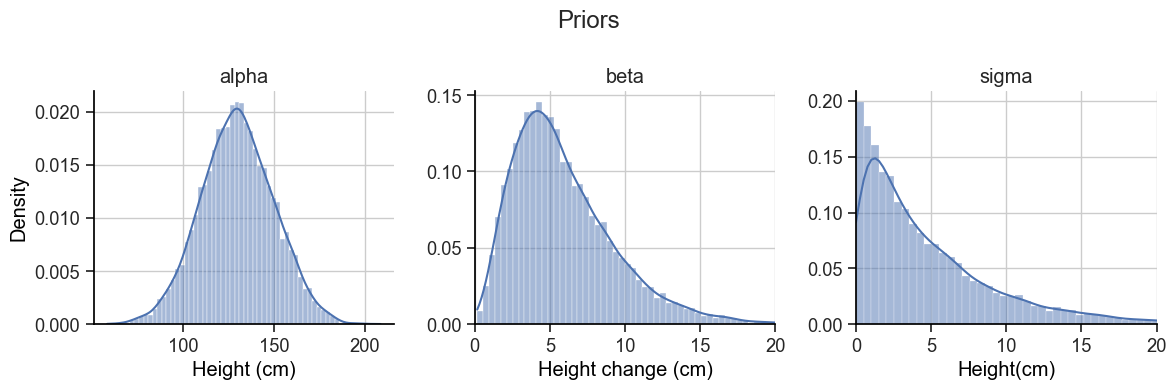

In [125]:
beta_prior = stats.gamma(a=3, scale=2)

fig, axs = plot_child_height_against_time_priors(alpha_prior, beta_prior, sigma_prior, n_sample=10000)

axs[1].set(xlim=[0, 20])
axs[2].set(xlim=[0, 20])
plt.tight_layout()

### 4M6

Now suppose I tell you that the variance among heights for students of the same age is never more than 64cm.
How does this lead you to revise your priors?

---

If variance is less than 64 then standard deviation is less than 8. We could use this to tighten the prior on sigma a little.

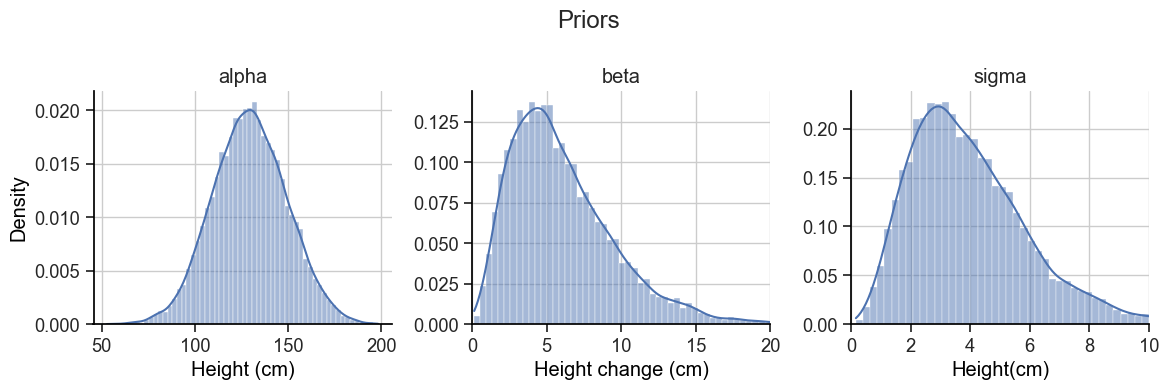

In [131]:
beta_prior = stats.gamma(a=3, scale=2)
sigma_prior = stats.gamma(a=4, scale=1)

fig, axs = plot_child_height_against_time_priors(alpha_prior, beta_prior, sigma_prior, n_sample=10000)

axs[1].set(xlim=[0, 20])
axs[2].set(xlim=[0, 10])
plt.tight_layout()

There is still some density above 8 but not very much.

### 4M7

Refit model `m4.3` from the chapter, but omit the mean weight `xbar` this time.
Compare the new model’s posterior to that of the original model.
In particular, look at the covariance among the parameters.
What is different?
Then compare the posterior predictions of both models.

---

In [132]:
# reload the data
howell = load_data(HOWELL_FILE, delimiter=";")
adult = howell.loc[howell["age"] >= 18, :]

First we respecify the original model:

In [154]:
with pm.Model() as m4_3:
    # priors
    alpha = pm.Normal("alpha", mu=178, sigma=20)
    beta = pm.LogNormal("beta", mu=0, sigma=1)
    sigma = pm.Uniform("sigma", lower=0, upper=50)

    # data
    weight = pm.MutableData("weight", adult.weight)

    # deterministic
    mu = pm.Deterministic("mu", alpha + beta * (weight - weight.mean()))

    # observed
    height = pm.Normal("height", mu=mu, sigma=sigma, observed=adult.height)

    # sample posterior
    trace_4_3 = pm.sample(1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [alpha, beta, sigma]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 1 seconds.


Now repeat without centring around the mean:

In [155]:
with pm.Model() as m4_3a:
    # priors
    alpha = pm.Normal("alpha", mu=178, sigma=20)
    beta = pm.LogNormal("beta", mu=0, sigma=1)
    sigma = pm.Uniform("sigma", lower=0, upper=50)

    # data
    weight = pm.MutableData("weight", adult.weight)

    # deterministic
    mu = pm.Deterministic("mu", alpha + beta * weight)

    # observed
    height = pm.Normal("height", mu=mu, sigma=sigma, observed=adult.height)

    # sample posterior
    trace_4_3a = pm.sample(1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [alpha, beta, sigma]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 2 seconds.


First compare the posteriors

In [156]:
az.summary(
    trace_4_3,
    var_names=["alpha", "beta", "sigma"],
    kind="stats",
    hdi_prob=0.89,
    round_to=2,
)

mean    sd  hdi_5.5%  hdi_94.5%
alpha  154.60  0.27    154.17     155.02
beta     0.90  0.04      0.84       0.97
sigma    5.11  0.19      4.80       5.41

In [157]:
az.summary(
    trace_4_3a,
    var_names=["alpha", "beta", "sigma"],
    kind="stats",
    hdi_prob=0.89,
    round_to=2,
)

mean    sd  hdi_5.5%  hdi_94.5%
alpha  114.57  1.82    111.66     117.39
beta     0.89  0.04      0.83       0.95
sigma    5.11  0.20      4.80       5.43

The mean of alpha is shifted down by 40 and it has much higher standard deviation.
Note that previously alpha represented the height at mean weight, but represents mean height at weight zero.
Since we have no data near weight zero, it makes sense that the uncertainty in alpha is now much higher.

Now let's compare the covariances.

In [168]:
trace_df = trace_4_3.posterior.drop("mu").mean(dim=["mu_dim_0"]).to_dataframe()
trace_df.cov().round(3)

alpha   beta  sigma
alpha  0.071  0.000 -0.001
beta   0.000  0.002  0.000
sigma -0.001  0.000  0.037

In [169]:
trace_df = trace_4_3a.posterior.drop("mu").mean(dim=["mu_dim_0"]).to_dataframe()
trace_df.cov().round(3)

alpha   beta  sigma
alpha  3.312 -0.072  0.012
beta  -0.072  0.002 -0.000
sigma  0.012 -0.000  0.039

The big difference here is that there are more significant off-diagonal entries.
Previously alpha and beta were uncorrelated, but now they are significantly correlated.

In [165]:
def plot_posterior_compatibility_interval_for_linear_height_model(trace, post_pred_sample, adult, ax=None):
    mu_mean = trace.posterior.mu.mean(dim=["chain", "draw"])
    mu_hdi = az.hdi(trace.posterior.mu, hdi_prob=0.89)
    mu_plot_data = pd.DataFrame(
        {
            "weight": trace.constant_data.weight,
            "mean": mu_mean,
            "hdi_lower": mu_hdi.mu.sel(hdi="lower"),
            "hdi_higher": mu_hdi.mu.sel(hdi="higher"),
        }
    ).sort_values("weight")

    height_hdi = az.hdi(post_pred_sample.posterior_predictive.height, hdi_prob=0.89)
    post_pred_plot_data = pd.DataFrame(
        {
            "weight": trace.constant_data.weight,
            "hdi_lower": height_hdi.height.sel(hdi="lower"),
            "hdi_higher": height_hdi.height.sel(hdi="higher"),
        }
    ).sort_values("weight")

    if not ax:
        fig, ax = plt.subplots(figsize=(6, 5))

    # plot true data
    sns.scatterplot(adult, x="weight", y="height", ax=ax)

    # plot the mean at each weight
    ax.plot(mu_plot_data["weight"], mu_plot_data["mean"], color="k")

    # mu HDI
    ax.fill_between(
        mu_plot_data["weight"],
        mu_plot_data["hdi_lower"],
        mu_plot_data["hdi_higher"],
        color="k",
        alpha=0.3,
    )

    # posterior predictive HDI
    ax.fill_between(
        post_pred_plot_data["weight"],
        post_pred_plot_data["hdi_lower"],
        post_pred_plot_data["hdi_higher"],
        color="k",
        alpha=0.1,
    )

    ax.set(title="Posterior compatibility interval")

In [166]:
with m4_3:
    post_pred_sample_4_3 = pm.sample_posterior_predictive(trace_4_3a)

with m4_3a:
    post_pred_sample_4_3a = pm.sample_posterior_predictive(trace_4_3a)

Sampling: [height]


Sampling: [height]


Text(0.5, 0.98, 'Posterior compatibility intervals')

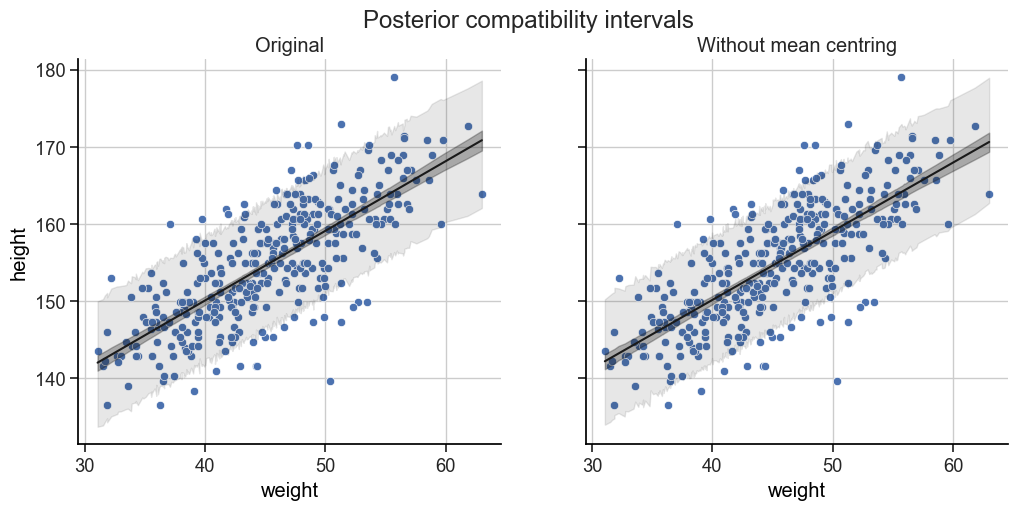

In [167]:
fig, axs = plt.subplots(ncols=2, sharey=True, figsize=(12, 5))

plot_posterior_compatibility_interval_for_linear_height_model(trace_4_3, post_pred_sample_4_3, adult, ax=axs[0])
plot_posterior_compatibility_interval_for_linear_height_model(trace_4_3a, post_pred_sample_4_3a, adult, ax=axs[1])

axs[0].set_title("Original")
axs[1].set_title("Without mean centring")

fig.suptitle("Posterior compatibility intervals");

The posterior predictions appear to be identical.

### 4M8

In the chapter, we used 15 knots with the cherry blossom spline.
Increase the number of knots and observe what happens to the resulting spline.
Then adjust also the width of the prior on the weights—change the standard deviation of the prior and watch what happens.
What do you think the combination of knot number and the prior on the weights controls?

---

I'll do it with some smaller knot values because mine runs so slowly for some reason.

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [alpha, beta, sigma]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 8 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details


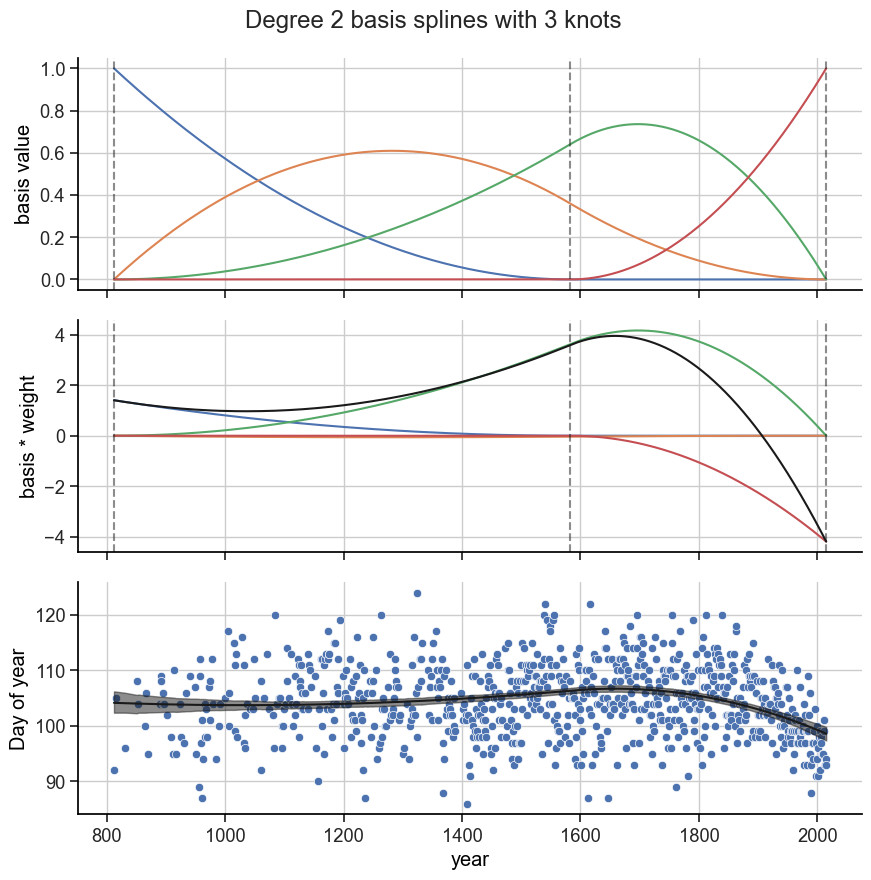

In [66]:
model, trace = fit_and_plot_spline_model(cherry, n_knots=3, deg=2)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [alpha, beta, sigma]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 8 seconds.


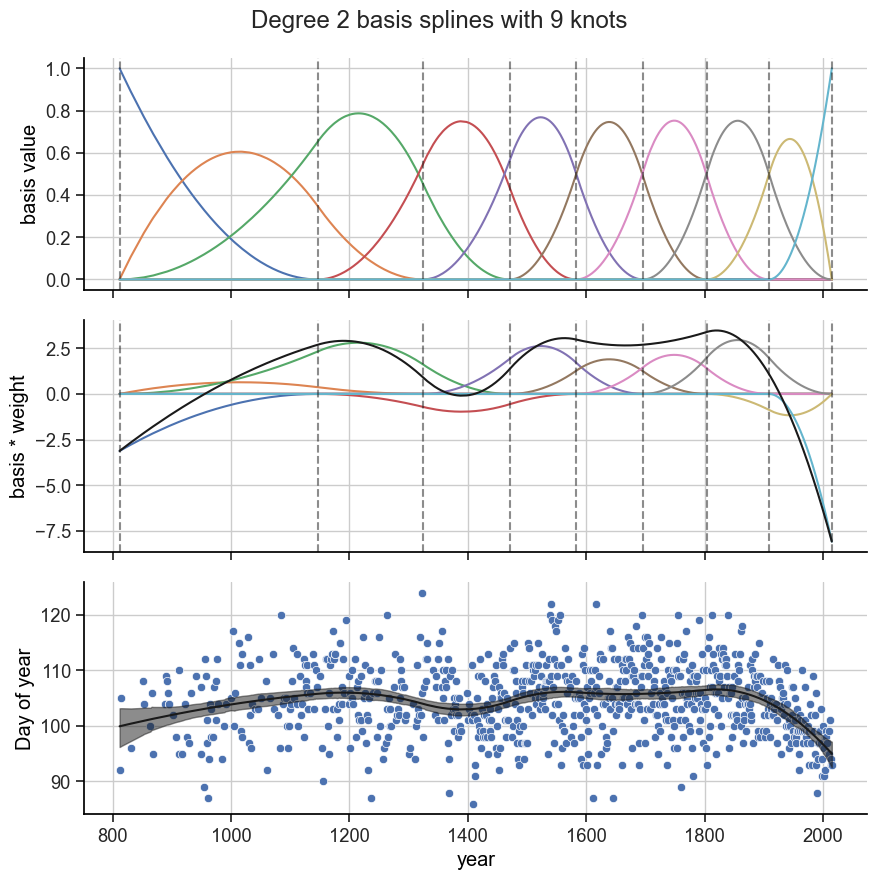

In [67]:
model, trace = fit_and_plot_spline_model(cherry, n_knots=9, deg=2)

You can see that adding more knots makes the resulting curve more flexible.

Now try a tighter prior on the standard deviation.

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [alpha, beta, sigma]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 2 seconds.


(alpha ~ Normal(100, 10)
  beta ~ Normal(0, 1)
 sigma ~ Exponential(f())
    mu ~ Deterministic(f(alpha, beta))
   doy ~ Normal(mu, sigma),
 Inference data with groups:
 	> posterior
 	> sample_stats
 	> observed_data
 	> constant_data)

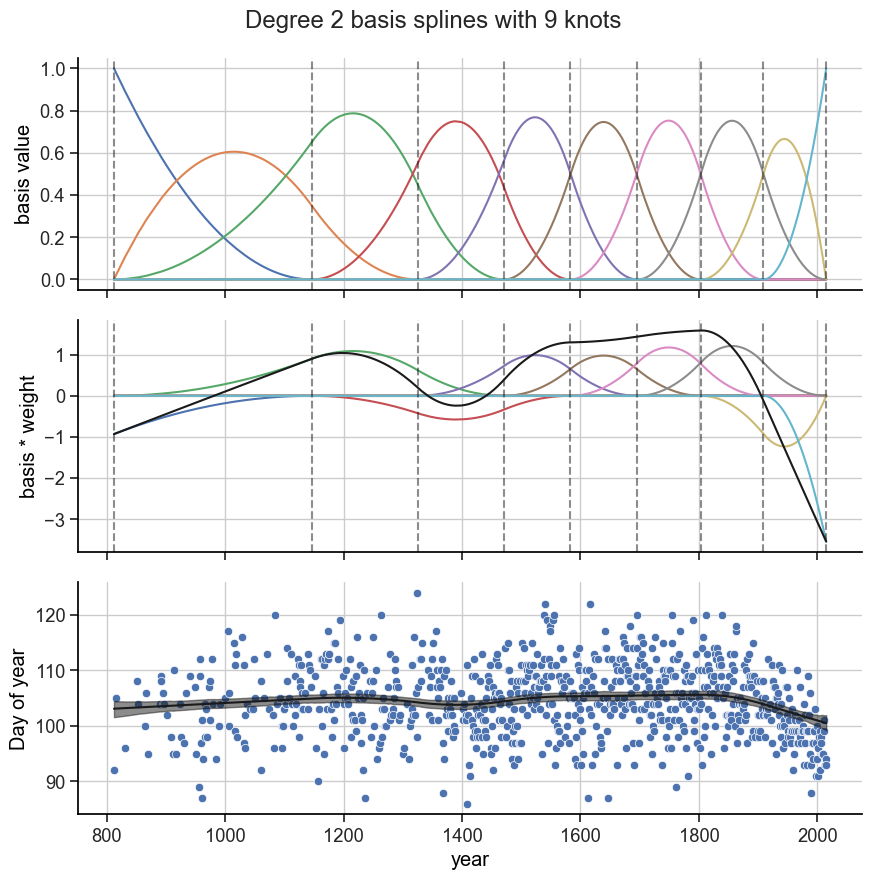

In [68]:
model, trace = fit_and_plot_spline_model(cherry, n_knots=9, deg=2, beta_prior_sigma=1)

With a tighter prior there is less flexibility in the curve.

## Hard

### 4H1

The weights listed below were recored in the !Kung census, but heights were not recorded for these individuals.
Provide predicted heights and 89% intervals for each of these individuals.
That is, fill in the table, below, using model-based predictions.

| Individual      | weight          | expected height | 89% interval    |
|-----------------|-----------------|-----------------|-----------------|
| 1               | 47.0            |                 |                 |
| 2               | 43.7            |                 |                 |
| 3               | 64.8            |                 |                 |
| 4               | 32.6            |                 |                 |
| 5               | 54.6            |                 |                 |

---

In [ ]:
# reload the data
howell = load_data(HOWELL_FILE, delimiter=";")
adult = howell.loc[howell["age"] >= 18, :]

I will assume that these are adults and so use model 4.3.
First respecify the model.

Note: we need to specify that the dimensions for weight, mu, and height are the same to allow us to change the weight values for prediction.

In [173]:
with pm.Model() as m4_3:
    # priors
    alpha = pm.Normal("alpha", mu=178, sigma=20)
    beta = pm.LogNormal("beta", mu=0, sigma=1)
    sigma = pm.Uniform("sigma", lower=0, upper=50)

    # data
    weight = pm.MutableData("weight", adult.weight, dims="obs_id")

    # deterministic
    mean_weight = adult.weight.mean()
    mu = pm.Deterministic("mu", alpha + beta * (weight - mean_weight.mean()), dims="obs_id")

    # observed
    height = pm.Normal("height", mu=mu, sigma=sigma, observed=adult.height, dims="obs_id")

    # sample posterior
    trace_4_3 = pm.sample(1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [alpha, beta, sigma]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 1 seconds.


Now we generate posterior predictions using the new weight values

In [174]:
predictions = pd.DataFrame({
    "individual": range(1, 6),
    "weight": [47.0, 43.7, 64.8, 32.6, 54.6],
})

with m4_3:
    pm.set_data({"weight": predictions.weight})    
    trace_4_3 = pm.sample_posterior_predictive(
        trace_4_3,
        var_names=["mu", "height"],
        extend_inferencedata=True,
        predictions=True,
    )

Sampling: [height]


The values are stored in 'predictions'

In [175]:
trace_4_3

Inference data with groups:
	> posterior
	> predictions
	> sample_stats
	> observed_data
	> constant_data
	> predictions_constant_data

For expected height we take the mean value for mu

In [188]:
predictions["expected_height"] = trace_4_3.predictions.mu.mean(dim=["chain", "draw"]).round(2)

To get the interval we take an HDI of the height values.

In [190]:
predictions[["interval_lower", "interval_higher"]] = az.hdi(trace_4_3.predictions.height, hdi_prob=0.89).height.round(2)

In [191]:
predictions

individual  weight       lower      higher  expected_height   
0           1    47.0  148.535597  165.134266           156.41  \
1           2    43.7  145.168607  161.678637           153.43   
2           3    64.8  164.535428  181.108490           172.49   
3           4    32.6  134.893787  151.216923           143.41   
4           5    54.6  155.262964  171.817436           163.28   

   interval_lower  interval_higher  
0          148.54           165.13  
1          145.17           161.68  
2          164.54           181.11  
3          134.89           151.22  
4          155.26           171.82

### 4H2

Select out all the rows in the Howell1 data with ages below 18 years of age.
If you do it right, you should end up with a new data frame with 192 rows in it.

(a) Fit a linear regression to these data, using `quap`. Present and interpret the estimates. For every 10 units of increase in weight, how much taller does the model predict a child gets?

(b) Plot the raw data, with height on the vertical axis and weight on the horizontal axis. Superimpose the MAP regression line and 89% interval for the mean. Also superimpose the 89% interval for predicted heights.

---

In [192]:
# reload the data
howell = load_data(HOWELL_FILE, delimiter=";")
child = howell.loc[howell["age"] < 18, :]
child.shape

(192, 4)